### Colorectal Cancer Data Analysis
The notebook is going to guide throught the exploration and analysis of the given colorectal cancer datset, composed by:
1. A gene expression dataset, containing raw counts of gene expression per patient;
2. A clinical dataset, containing clinical data for the patient of the aforementioned expression dataset.

Note: biopsy site and sample type have been used as covariates for the data aggregation.

These are the steps I have taken to perform the analysis:
1. Cleaning of the clinical dataset;
2. Exploration of the two datasets;
3. Possible analyses discussion;
4. Selected analyses.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys

import gseapy
from pydeseq2.ds import DeseqStats
from lifelines.statistics import logrank_test

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '.'))
src_dir = os.path.join(parent_dir, 'src')
sys.path.append(src_dir)

In [3]:
import settings, data_loader, data_manipulator, plotter

In [4]:
pd.set_option('display.max_columns', 500)

### STEP 1: CLEAN DATASET ROWS
1. First I verify index uniqueness;
2. Then I verify the patients/donors ids uniqueness.

In [5]:
clinical_data = data_loader.load_clinical_data()

In [6]:
data_manipulator.verify_index_uniqueness(clinical_data)

True

then, verify that the gtex an tcga donors/participants are unique.

1. TCGA sample names have a barcode that specifies (also) the [participant id](https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/).
2. GTEX sample names have as well a barcode that specifies (also) the [donor id](https://sites.google.com/broadinstitute.org/gtex-faqs/home).
3. GSM sample names have an unique identifier after the GSM. By checking that the index ids are unique, I already veryfied that the samples have unique donor.

In [7]:
data_manipulator.verify_all_index_participant_unique(clinical_data)

COLUMNS IN GTEX WHERE THERE IS DIFFERENCE BETWEEN ROWS WITH SAME DONOR: {('Biopsy subsite', 'Distal vs proximal')}

GTEX set is 555; list is 779.

COLUMNS IN TCGA WHERE THERE IS DIFFERENCE BETWEEN ROWS WITH SAME DONOR: {(), ('BRAF mutation',), ('Biopsy timepoint',)}

TCGA set is 616; list is 631.



False

In [8]:
tcga_rows_to_consolidate = data_manipulator.get_double_donor_rows(clinical_data, 2, "TCGA")

In [9]:
for rows in tcga_rows_to_consolidate:
#     print(f"passing by {rows}")
    to_keep = data_manipulator.consolidate_columns(clinical_data.loc[rows])
#     print(f"To keep: {to_keep[0]}")
    rows.remove(to_keep[0])
    for row in rows:
        clinical_data.drop(row, axis=0, inplace=True)
    if len(to_keep)>1: 
        for col in to_keep[1]:
            clinical_data.loc[to_keep[0],col] = np.nan

Comment:  
1. GTEX has samples from the same donor in different places (distal and proximal colon). I can use this for analysis between distal and proximal expression. (normal vs tumor in distal or proximal). At this point I keep both samples from the same donor. This way I could do a differential analysis based on the place where the tumor is coming from, having healthy data on both places.
2. TCGA has differences in the same samples that are more diverse, usually one sample has less data than the other (so I keep the one with more data) and I set as NANs all the values from columns that disagree (like mutation WT or MUTATED).

Plotting NaNs pattern

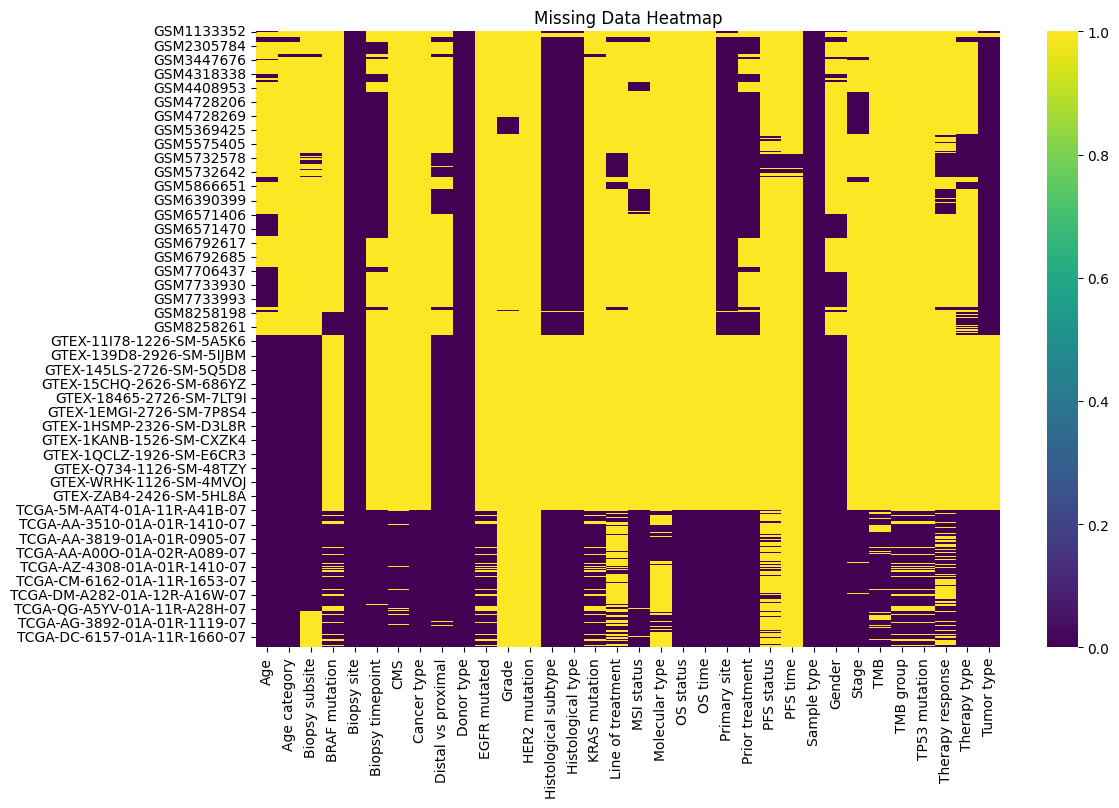

In [10]:
data_manipulator.exploreNaNs(clinical_data)

Consideration: this dataset is a collage of clinical data from 3 different datasets: 
1. GSM is referred to Gene Expression Omnibus data. It contains both tumor and normal tissue samples.
2. GTEX is referred to Genotype-Tissue Expression and it contains non-disease tissue samples.
3. TCGA is referred to The Cancer Genome Atlas and contains primary cancer and matched normal samples.

Verifying that the indexes have as prefix only "GSM", "GTEX", "TCGA"

In [11]:
data_manipulator.verify_clinical_df_index_prefixes(clinical_data)

GSM has 1360
GTEX has 779
TCGA has 616
All rows are in GSM, GTEX, TCGA


I now add a column flagging the dataset of origin to then verify if batch effects is (still in place)

In [12]:
clinical_data["source"] = data_manipulator.infer_dataset_from_index(clinical_data)

In [13]:
clinical_data["source"].unique()

array(['GSM', 'GTEX', 'TCGA'], dtype=object)

Listing out all columns names:

In [14]:
list(clinical_data.columns.values)

['Age',
 'Age category',
 'Biopsy subsite',
 'BRAF mutation',
 'Biopsy site',
 'Biopsy timepoint',
 'CMS',
 'Cancer type',
 'Distal vs proximal',
 'Donor type',
 'EGFR mutated',
 'Grade',
 'HER2 mutation',
 'Histological subtype',
 'Histological type',
 'KRAS mutation',
 'Line of treatment',
 'MSI status',
 'Molecular type',
 'OS status',
 'OS time',
 'Primary site',
 'Prior treatment',
 'PFS status',
 'PFS time',
 'Sample type',
 'Gender',
 'Stage',
 'TMB',
 'TMB group',
 'TP53 mutation',
 'Therapy response',
 'Therapy type',
 'Tumor type',
 'source']

Consideration: columns refer to different kind of data. There is 
1. 'anagraphic' data (like age and gender);
2. marker data (like known genes mutation, TMB, CMS, MSI);
3. tumor-specific data (like cancer/tumor type, donor, grade, stage)
4. clinical data (like treatment, therapy, OS).

I will divide these data into different categories as it can be used for different analysis directions.  
Moreover, as GTEX contains normal tissue samples, it lacks labels in most of non-anagraphic columns.

### STEP 2 - CLEANING AND EXPLORING THE CLINICAL DATASET

#### Aggregating the tumor sample origin data (columns Biopsy subsite, Biopsy site, Primary site, Distal vs Proximal)
Based on [this report](https://www.cancer.org/content/dam/cancer-org/research/cancer-facts-and-statistics/colorectal-cancer-facts-and-figures/colorectal-cancer-facts-and-figures-2023.pdf) I can see that the colorectal cancer is labled to be found into 4 sites: Colon, Rectum, Colorectum, Rectosigmoid junction. 
There is redundancy given by the columns "biopsy site" and "primary site" as they both specify one of the 4 primary sites.

Moreover, as the colon is a quite large organ, it can be specified in left or right colon. Left colon is also called distal, while right colon is also called proximal.
This means that biopsy subsite (which contains only left or right column values) and distal vs proximal (which contain distal or proximal values) are redundant.

I cannot collapse all 4 columns into 1 as not all columns whose site is column have a distinction into distal or proximal.

First I validate that the two columns correspond

In [15]:
column_1 = 'Biopsy site'
column_2 = 'Primary site'

for biopsy_site in settings.BIOPSY_SITES:
    discordance_mask = data_manipulator.verify_concordance_columns_on_value(clinical_data, column_1, column_2, biopsy_site)
    print(f"FOUND {discordance_mask.sum()} discordant rows for value '{biopsy_site}' between '{column_1}' and '{column_2}'")

FOUND 0 discordant rows for value 'Colon' between 'Biopsy site' and 'Primary site'
FOUND 0 discordant rows for value 'Rectum' between 'Biopsy site' and 'Primary site'
FOUND 0 discordant rows for value 'Colorectum' between 'Biopsy site' and 'Primary site'
FOUND 0 discordant rows for value 'Rectosigmoid junction' between 'Biopsy site' and 'Primary site'


As "Biopsy site" does not have NaNs, I just drop "Primary site"

In [16]:
clinical_data.drop("Primary site", axis=1, inplace=True)

Then I merge "Biopsy subsite" and "Distal vs Proximal"

In [17]:
subsite_mapping: dict = {"Right colon": "Proximal", "Left colon": "Distal"}

In [18]:
clinical_data['Biopsy subsite'] = clinical_data['Biopsy subsite'].map(subsite_mapping)

In [19]:
clinical_data['colon_subsite'] = clinical_data['Distal vs proximal'].combine_first(clinical_data['Biopsy subsite'])

In [20]:
clinical_data = clinical_data.drop('Distal vs proximal', axis=1)

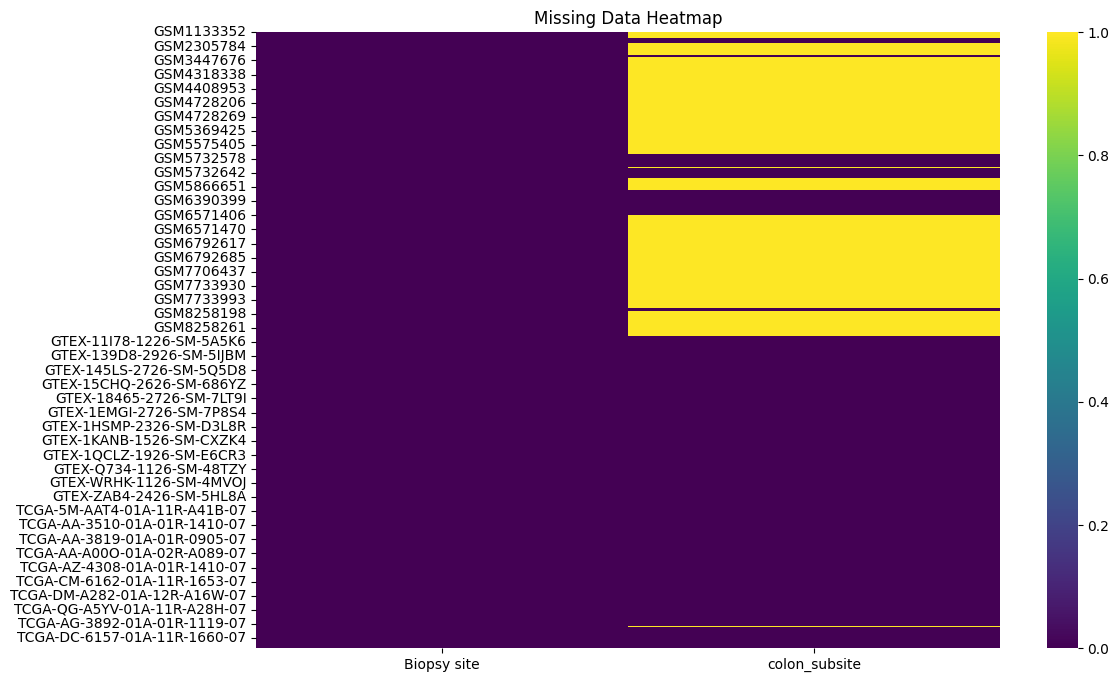

In [21]:
data_manipulator.exploreNaNs(clinical_data[["Biopsy site", "colon_subsite"]])

Dropping some columns not very useful

In [22]:
clinical_data = clinical_data.drop(settings.DROP_SELECTED_COLUMS, axis=1)

Exploring tumor-related features. I want to see how they are distributed

In [23]:
df_tumor = clinical_data[[el for el in settings.TUMOR_METRICS if el not in settings.DROP_SELECTED_COLUMS]]

In [24]:
df_tumor.describe()

Donor type Grade Histological subtype Histological type Stage
count        2755    79                 1951              1951   821
unique          2     3                   14                 5     4
top         Tumor    II       Adenocarcinoma          Neoplasm   III
freq         1951    45                  842               974   300

In [25]:
for col in df_tumor.columns:
    data_manipulator.print_counts(df_tumor, col)

----------
Donor type counts: Donor type
Tumor     1951
Normal     804
Name: count, dtype: Int64

----------
Grade counts: Grade
II     45
III    26
I       8
Name: count, dtype: Int64

----------
Histological subtype counts: Histological subtype
Adenocarcinoma                                        842
Malignant tumor                                       738
Unknown behavior neoplasm                             132
Neoplasm, metastatic                                  104
Mucinous adenocarcinoma                                79
Carcinoma                                              23
Adenocarcinoma, metastatic, NOS                        10
Adenocarcinoma in tubulovillous adenoma                 8
Tubular adenocarcinoma                                  5
Metastatic carcinoma                                    3
Adenocarcinoma with mixed subtypes                      3
Papillary adenocarcinoma, NOS                           2
Adenocarcinoma with neuroendocrine differentiation      1

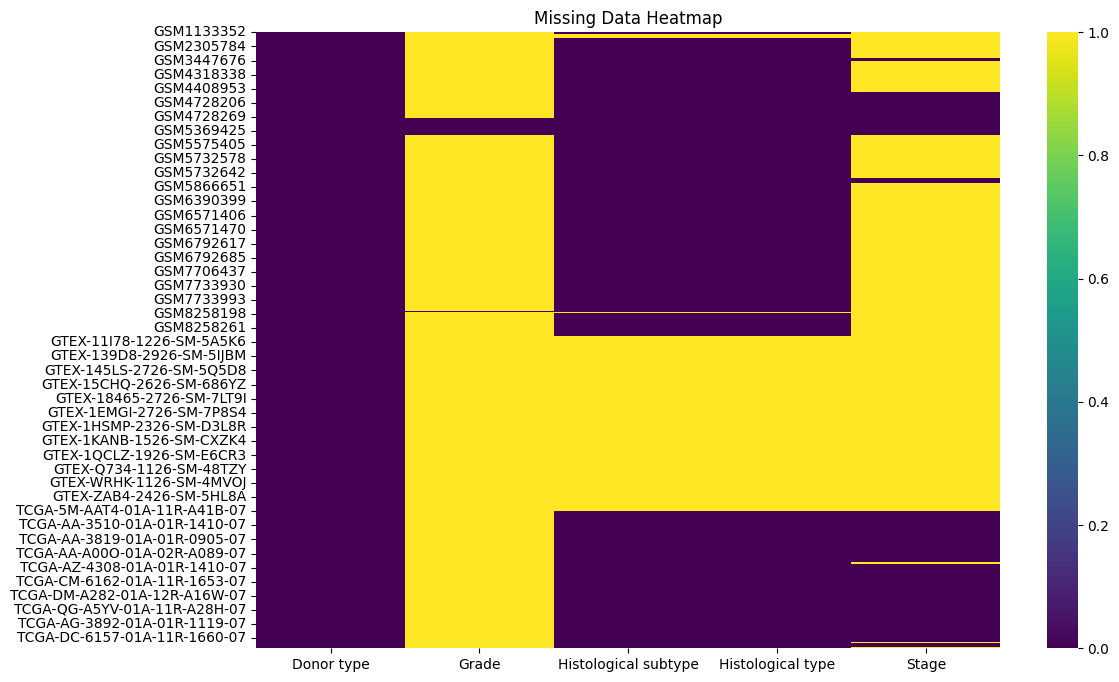

In [26]:
data_manipulator.exploreNaNs(df_tumor)

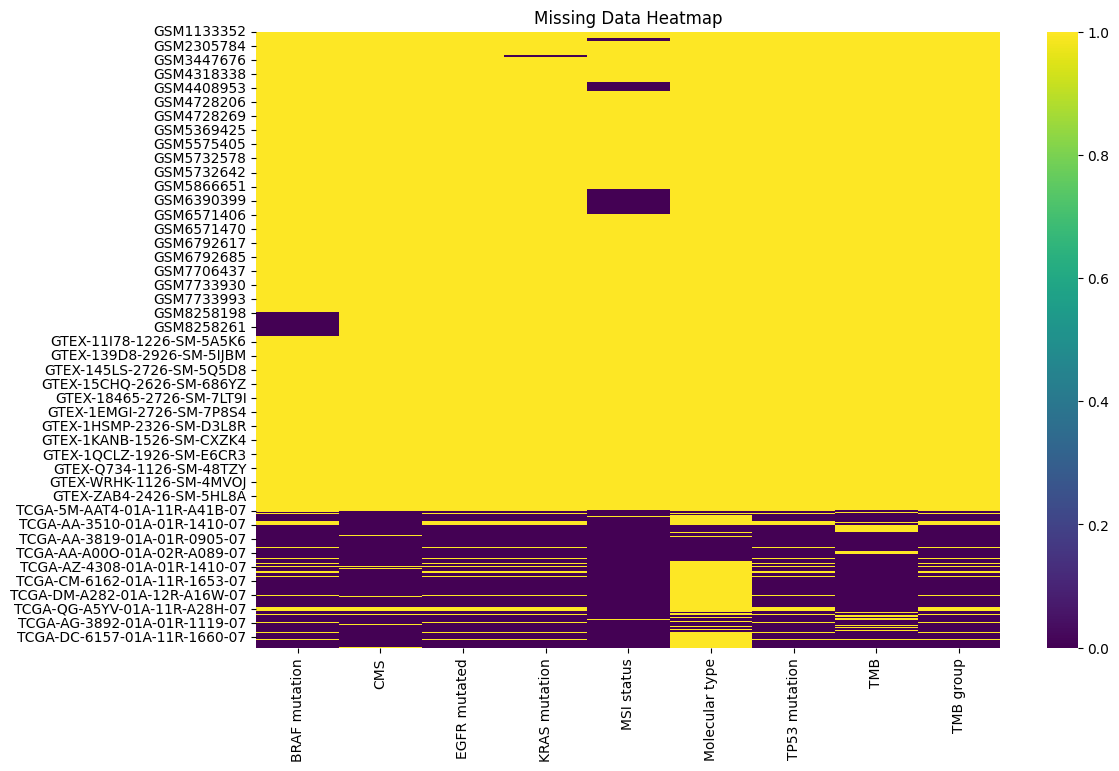

In [27]:
df_mutations = clinical_data[[el for el in settings.MUTATION_METRICS if el not in settings.DROP_SELECTED_COLUMS]]
data_manipulator.exploreNaNs(df_mutations)

In [28]:
df_mutations["TMB group"].unique()

<StringArray>
[<NA>, 'Low', 'High']
Length: 3, dtype: string

Setting the TMB group HIGH if > 10 else LOW.

In [29]:
# df_mutations[df_mutations["TMB group"] == 'High']["TMB"].describe()
# df_mutations[df_mutations["TMB group"] == 'Low']["TMB"].describe()
threshold = 10

has_value = pd.notna(df_mutations["TMB"])

# Only update rows where float_col has values
df_mutations.loc[has_value, "TMB group"] = np.where(
    df_mutations.loc[has_value, "TMB"] >= threshold,
    'High',
    'Low'
)

df_mutations = df_mutations.drop("TMB", axis=1)

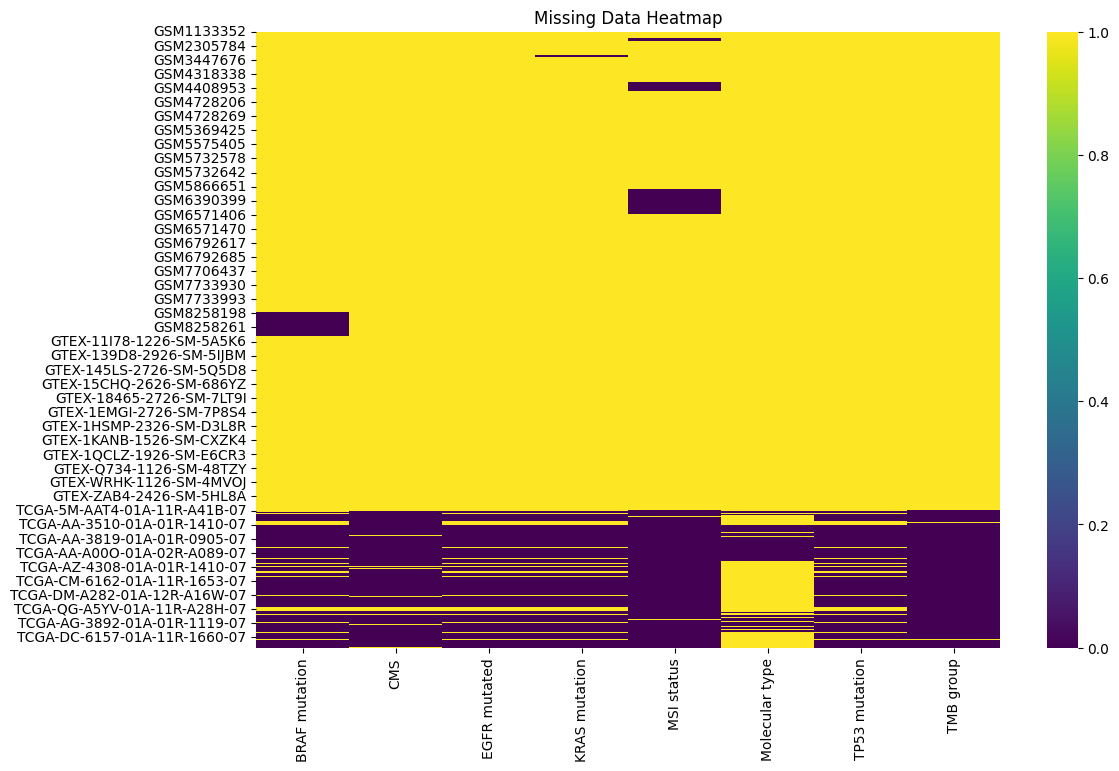

In [30]:
data_manipulator.exploreNaNs(df_mutations)

Consideration: any analysis on mutations is going to be done only on TCGA samples, i.e. the only ones that have actual data on it.\
I check the # of elements for each unique label in the columns to see if there are enough of both to do an analysis or is it better to drop.

In [31]:
for col in df_mutations.columns:
    data_manipulator.print_counts(df_mutations, col)

----------
BRAF mutation counts: BRAF mutation
WT         560
Mutated     56
Name: count, dtype: Int64

----------
CMS counts: CMS
CMS2     219
CMS4     139
CMS1      76
CMS3      72
NOLBL     60
Name: count, dtype: Int64

----------
EGFR mutated counts: EGFR mutated
WT         498
Mutated     15
Name: count, dtype: Int64

----------
KRAS mutation counts: KRAS mutation
WT         297
Mutated    226
Name: count, dtype: Int64

----------
MSI status counts: MSI status
MSS      544
MSI-H    128
MSI-L    102
Name: count, dtype: Int64

----------
Molecular type counts: Molecular type
CIMP-low                               41
Cluster 3                              40
Chromosomal instability | Cluster 4    40
Chromosomal instability | Cluster 3    36
CIMP-high                              35
Cluster 4                              30
Chromosomal instability | CIMP-low      8
Chromosomal instability | CIMP-high     1
Name: count, dtype: Int64

----------
TP53 mutation counts: TP53 mutation
Mutat

As EGFR gene has only 15 mutated, I will drop the column.

In [32]:
clinical_data = clinical_data.drop("EGFR mutated", axis=1)

Now exploring clinical labels

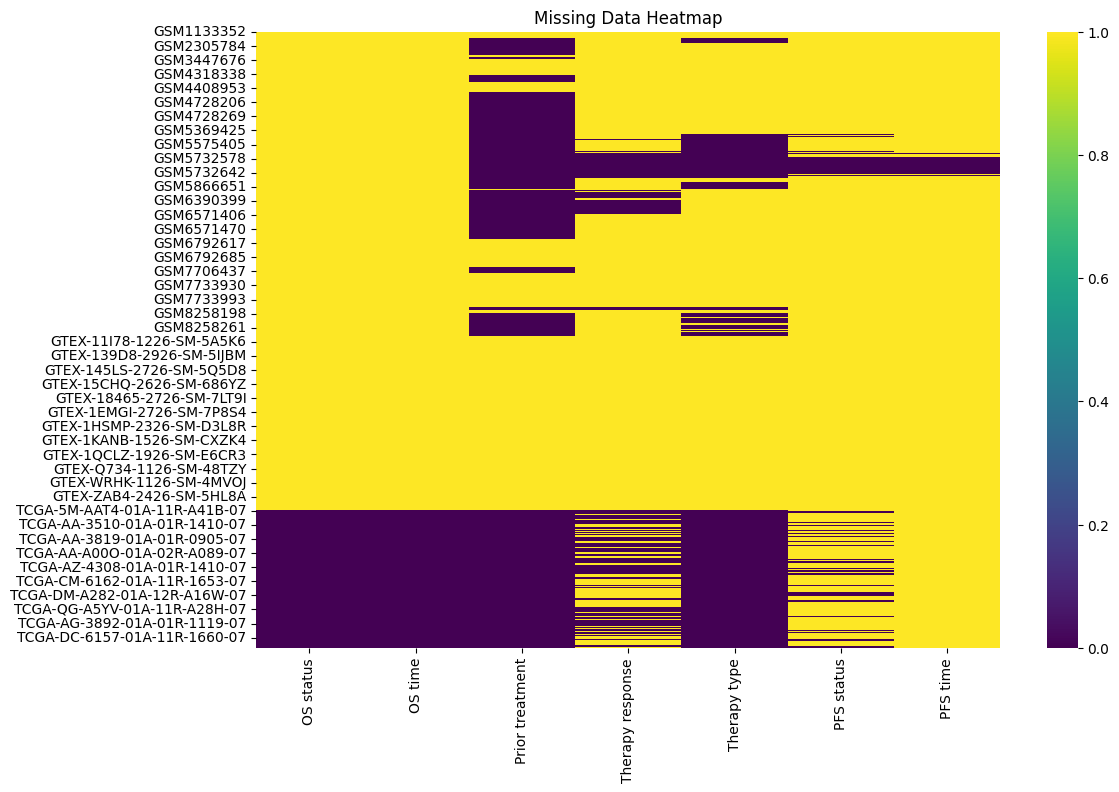

In [33]:
df_clinical = clinical_data[[el for el in settings.CLINICAL_METRICS if el not in settings.DROP_SELECTED_COLUMS]]
data_manipulator.exploreNaNs(df_clinical)

In [34]:
for col in df_clinical.columns:
    data_manipulator.print_counts(df_clinical, col)

----------
OS status counts: OS status
Censored    488
Dead        128
Name: count, dtype: Int64

----------
OS time counts: OS time
0      29
31     14
457     8
30      8
61      7
       ..
532     1
97      1
357     1
159     1
371     1
Name: count, Length: 390, dtype: Int64

----------
Prior treatment counts: Prior treatment
No     1403
Yes     130
Name: count, dtype: Int64

----------
Therapy response counts: Therapy response
CR       336
nonCR    161
PD        59
PR        18
SD         9
Name: count, dtype: Int64

----------
Therapy type counts: Therapy type
Not available | Radiotherapy                              205
Radiotherapy | Not available                              183
Chemotherapy | Radiotherapy                               111
Targeted therapy                                          100
Targeted therapy + Chemotherapy                            84
Radiotherapy | Chemotherapy                                80
Chemotherapy                                         

Finally at demographics labels

In [35]:
df_demographics = clinical_data[settings.DEMOGRAPHIC_METRICS]

#### removing duplicate gtex samples for demographics
As gtex has some samples that come from the same donors but from different locations, I drop the one in excess when analyzing the demographics

In [36]:
gtex_rows_to_consolidate = data_manipulator.get_double_donor_rows(df_demographics, 1, "GTEX")
to_drop = []
for rows in gtex_rows_to_consolidate:
    to_drop.extend(rows[1:])
    
df_demographics = df_demographics.drop(to_drop, axis=0)

In [37]:
for col in df_demographics.columns:
    data_manipulator.print_counts(df_demographics, col)

----------
Age counts: Age
54    191
64    177
44    101
34     61
24     55
     ... 
32      2
25      2
30      1
27      1
28      1
Name: count, Length: 65, dtype: Int64

----------
Gender counts: Gender
M    891
F    603
Name: count, dtype: Int64



### STEP 3: PLOT SOME METRICS

#### demographics metrics: Age distribution by gender of the data

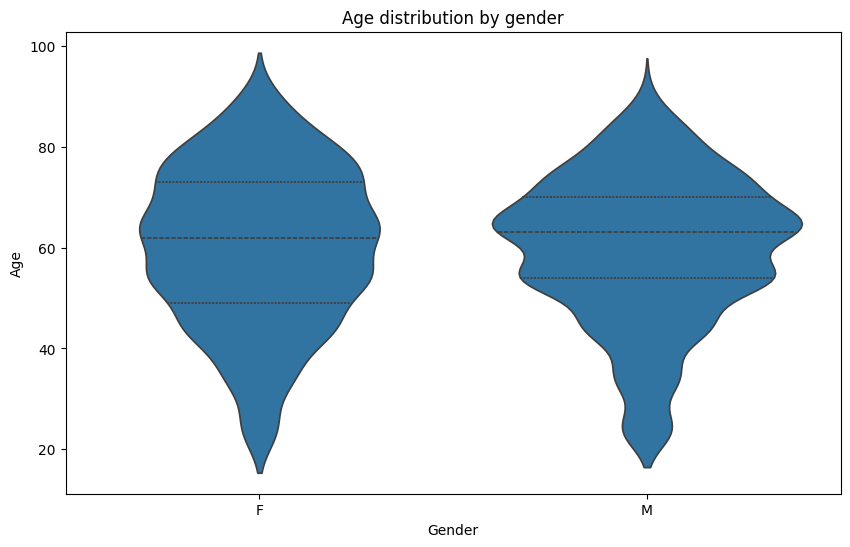

In [38]:
plotter.violin_xy(df_demographics, 'Gender', 'Age', 'Age distribution by gender')

#### MUTATIONS: co-occurrence between Micro-Satellite stability and Tumor Mutational Bourden
Rationale: MSI status can be Instable-high, Instable-low and Stable. Tumor Mutational Bourden can be high and low.
As both metrics are related to number of mutations, it might be possible that they are associated.  
Plotting the number of occurrences for each possible pair shows if there is any correlation.

In [39]:
mutation_occurence = pd.crosstab(df_mutations['MSI status'], df_mutations['TMB group'])
print(mutation_occurence)

TMB group   High  Low
MSI status           
MSI-H         80    6
MSI-L          2   99
MSS           10  403


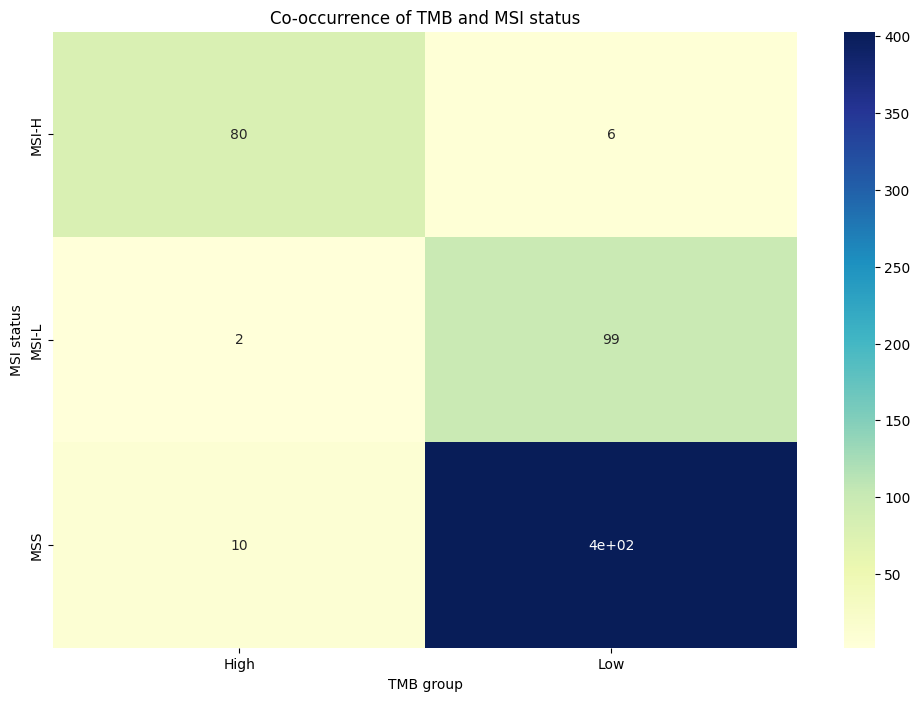

In [40]:
plotter.heatmap(mutation_occurence, "TMB group", "MSI status", "Co-occurrence of TMB and MSI status", colormap='YlGnBu')

### STEP 4: LOADING AND PREPROCESSING EXPRESSION DATA

In [41]:
expression_data = data_loader.load_expression_data()
expression_data.shape

(22723, 2770)

Straight away I remove the samples excluded by the clinical dataset

In [42]:
expression_data = expression_data.loc[:,expression_data.columns.isin(clinical_data.index)]
expression_data.shape

(22723, 2755)

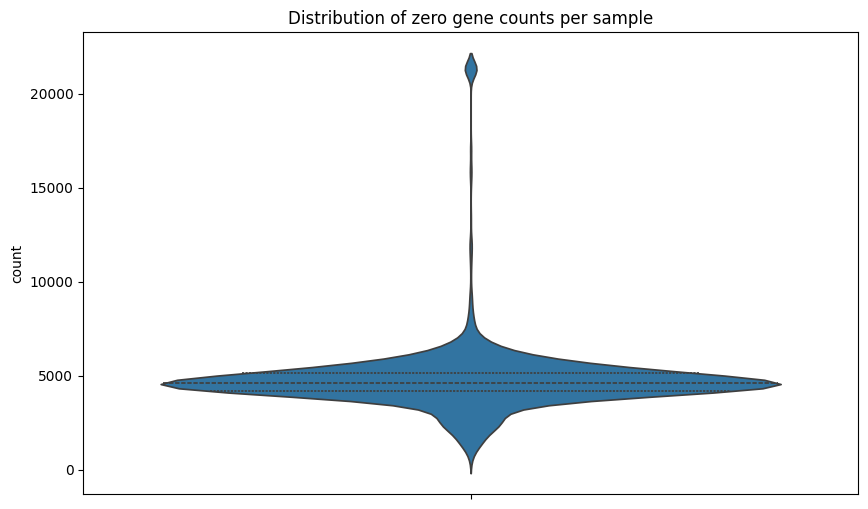

In [43]:
zero_rows_counts = (expression_data == 0).sum()
zero_rows_count_df = pd.DataFrame(zero_rows_counts, columns=['count'])

plotter.violin_y(zero_rows_count_df, 'count', 'Distribution of zero gene counts per sample')

I choose to cutoff genes that have more than 6000 genes at 0 value. This will discard 206 samples.

In [44]:
rows_zero_count_threshold = 6000
# zero_rows_count_df[zero_rows_count_df['count'] > rows_zero_count_threshold].count()
zero_rows_mask = (zero_rows_count_df['count'] > rows_zero_count_threshold)
samples_to_drop = clinical_data[zero_rows_mask].index.tolist()
len(samples_to_drop)

206

In [45]:
expression_data = expression_data.drop(samples_to_drop, axis=1)

In [46]:
total_genes_count = (expression_data == 0).sum(axis=1)
total_genes_count_df = pd.DataFrame(total_genes_count, columns=['total count'])
total_genes_count_df.describe()

total count
count  22723.000000
mean     498.230339
std      811.356098
min        0.000000
25%        0.000000
50%        4.000000
75%      737.000000
max     2546.000000

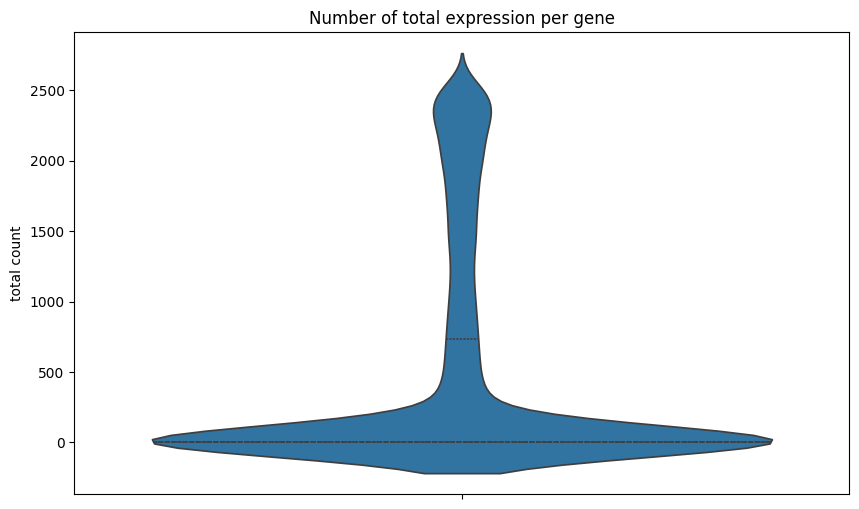

In [47]:
plotter.violin_y(total_genes_count_df, 'total count', 'Number of total expression per gene')

In [48]:
expression_data[expression_data.sum(axis=1) < 10000]

GSM1133352  GSM1133353  GSM2042099  GSM2042100  GSM2042101  \
A3GALT2             0.0         0.0         0.0         0.0         6.0   
AACSP1              0.0         1.0         0.0         1.0         5.0   
AADACL2-AS1         0.0         1.0         0.0         0.0         3.0   
AADACL3             0.0         0.0         0.0         0.0         0.0   
ABCC12              0.0        15.0         0.0         1.0         0.0   
...                 ...         ...         ...         ...         ...   
ZPBP                0.0         0.0         0.0         0.0         3.0   
ZPBP2               2.0         0.0         3.0         2.0         1.0   
ZSCAN10             0.0         4.0         1.0         2.0         0.0   
ZSCAN5B             1.0         0.0         2.0         1.0        18.0   
ZSWIM2              1.0         0.0         0.0         0.0         0.0   

             GSM2042102  GSM2042124  GSM2042125  GSM2042126  GSM2042127  \
A3GALT2             1.0         1.0         1.0         1.0         0.0   
AACSP1              0.0         0.0         1.0         1.0         0.0   
AADACL2-AS1         0.0         0.0         1.0         2.0         0.0   
AADACL3             0.0         0.0         0.0         0.0         0.0   
ABCC12              0.0         0.0         0.0         0.0         0.0   
...                 ...         ...         ...         ...         ...   
ZPBP                0.0         0.0         0.0         0.0         0.0   
ZPBP2               0.0         1.0         3.0         0.0         2.0   
ZSCAN10             1.0         0.0         0.0         0.0         0.0   
ZSCAN5B             3.0         3.0         3.0         3.0         1.0   
ZSWIM2              0.0         0.0         0.0         0.0         0.0   

             GSM2042128  GSM2042129  GSM2042130  GSM2042131  GSM2042132  \
A3GALT2             1.0         0.0         1.0         0.0         0.0   
AACSP1              0.0         0.0         0.0         1.0         0.0   
AADACL2-AS1         0.0         0.0         1.0         0.0         1.0   
AADACL3             0.0         0.0         0.0         0.0         0.0   
ABCC12              0.0         0.0         0.0         0.0         0.0   
...                 ...         ...         ...         ...         ...   
ZPBP                0.0         1.0         0.0         0.0         1.0   
ZPBP2               0.0         2.0         2.0         0.0         1.0   
ZSCAN10             0.0         0.0         0.0         0.0         0.0   
ZSCAN5B             2.0         2.0         2.0         2.0         0.0   
ZSWIM2              0.0         0.0         0.0         0.0         0.0   

             GSM2042133  GSM2042134  GSM2042135  GSM2042136  GSM2042137  \
A3GALT2             0.0         0.0         0.0         0.0         0.0   
AACSP1              0.0         1.0         1.0         0.0         0.0   
AADACL2-AS1         0.0         0.0         0.0         2.0         1.0   
AADACL3             0.0         0.0         0.0         0.0         0.0   
ABCC12              0.0         0.0         0.0         0.0         0.0   
...                 ...         ...         ...         ...         ...   
ZPBP                0.0         0.0         0.0         0.0         0.0   
ZPBP2               0.0         0.0         0.0         0.0         1.0   
ZSCAN10             0.0         0.0         0.0         0.0         0.0   
ZSCAN5B             2.0         5.0         4.0         1.0         2.0   
ZSWIM2              0.0         0.0         0.0         0.0         0.0   

             GSM2042138  GSM2042139  GSM2042140  GSM2042141  GSM2042142  \
A3GALT2             0.0         0.0         0.0         1.0         0.0   
AACSP1              0.0         0.0         0.0         0.0         0.0   
AADACL2-AS1         0.0         0.0         1.0         0.0         0.0   
AADACL3             0.0         0.0         0.0         0.0         0.0   
ABCC12              0.0         0.

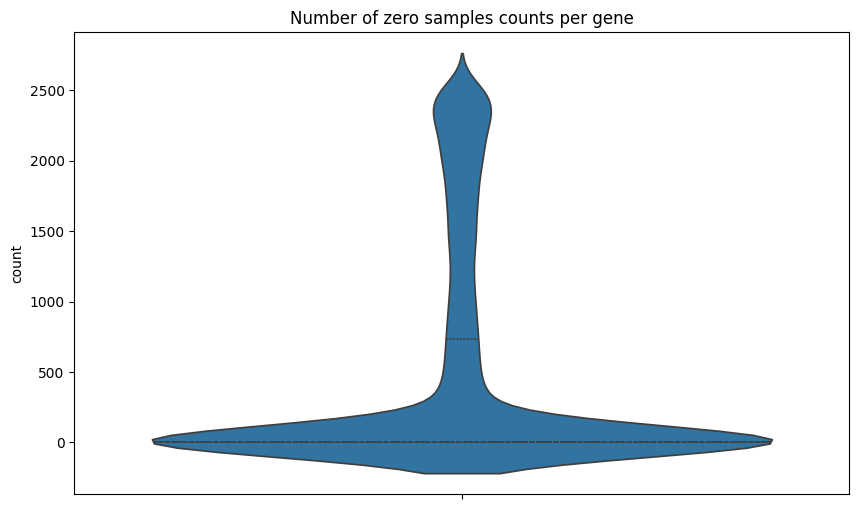

In [49]:
# filter also the genes and take out the ones that occurr in < 10% of samples
zero_row_count = (expression_data == 0).sum(axis=1) 
zero_row_count_df = pd.DataFrame(zero_row_count, columns=['count'])

plotter.violin_y(zero_row_count_df, 'count', 'Number of zero samples counts per gene')

In [50]:
expression_data.shape

(22723, 2549)

Filtering the expression data of genes that occurr on less than 20% of the samples.

In [51]:
min_samples = int(0.2 * expression_data.shape[1])
print(min_samples)
# non_zero_row_count_df[non_zero_row_count_df['count'] < min_samples].count()
print((zero_row_count_df['count'] > min_samples).sum())

509
6354


In [52]:
genes_to_drop = zero_row_count_df[zero_row_count_df['count'] > min_samples].index


In [53]:
expression_data = expression_data.drop(genes_to_drop, axis=0)

##### now passing to log data + scikit normalize to reduce skewness and do PCA

In [111]:
expr_normalized = data_manipulator.normalize_expression_data(expression_data)

#### EXPLORATORY ANALYSIS OF EXPRESSION DATA

In [122]:
num_components = 4
gtex_cols = clinical_data[clinical_data['source'] == 'GTEX'].index
sex_expr = expression_data.loc[:,gtex_cols]

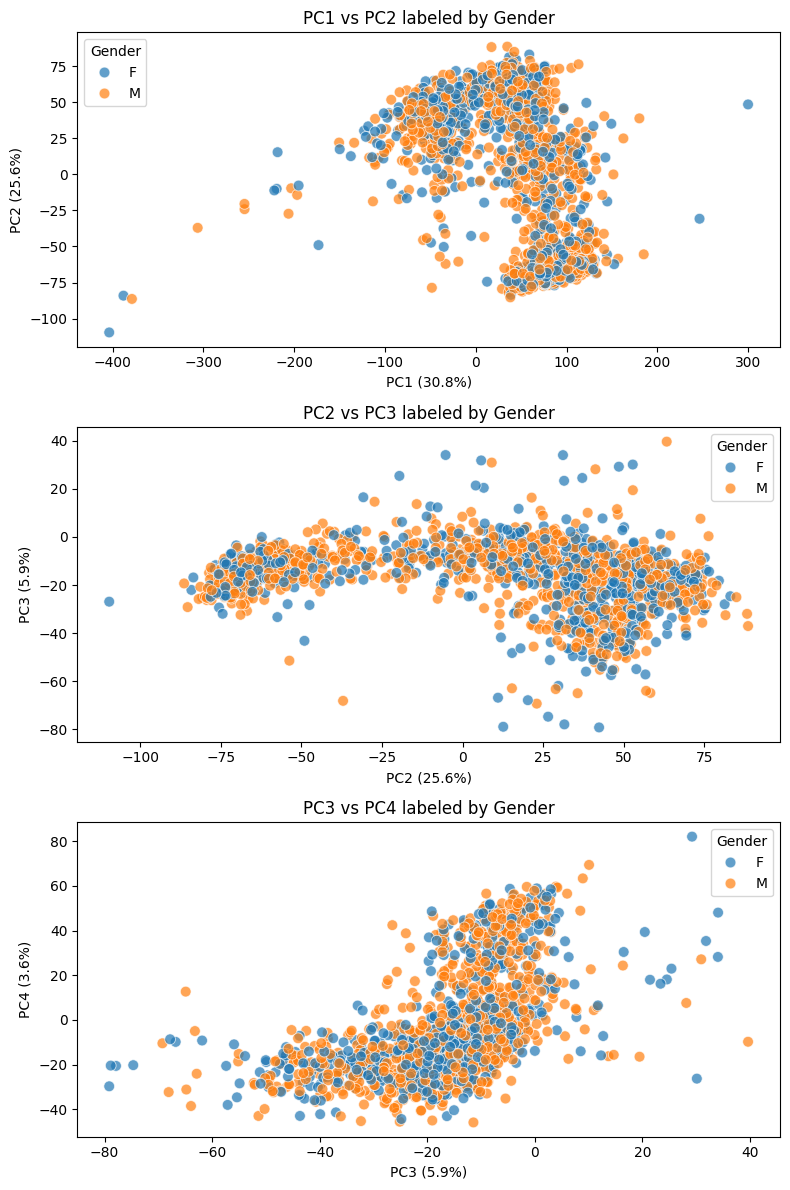

In [123]:
sex_expr_normalized = data_manipulator.normalize_expression_data(sex_expr)
pca_df, pca = data_manipulator.get_pca_dataframe(sex_expr_normalized, sex_expr.columns, num_components)
sex_df_merged = pca_df.merge(clinical_data, left_index=True, right_index=True)
plotter.pca_components(pca_df_merged, pca, 'Gender', num_components) 

In [55]:
# Create PCA dataframe
num_components = 4
pca_df, pca = data_manipulator.get_pca_dataframe(expr_normalized, expression_data.columns, num_components)

In [56]:
pca_df_merged = pca_df.merge(clinical_data, left_index=True, right_index=True)
# pca_df_merged

Now I plot the PCA colouring samples based on different columns values.\
If everything is ok I expect to see strong difference at least by sample type (the cancer biology should heavily distinguish between healthy tissue and tumor) and source dataset (as it is highly correlated with the sample type: GTEx is healthy, TCGA is tumor, GEO is a bit of both).\
I am going then to check for demographics (age and sex) to see if they divide as well the data. In normal cases sex should be one of the primary dividers but possibly cancer will hide the signal.\
Then I am going to test for other data (biopsy site to see if it batch corrected) and other clinical variables to see if there is separation.

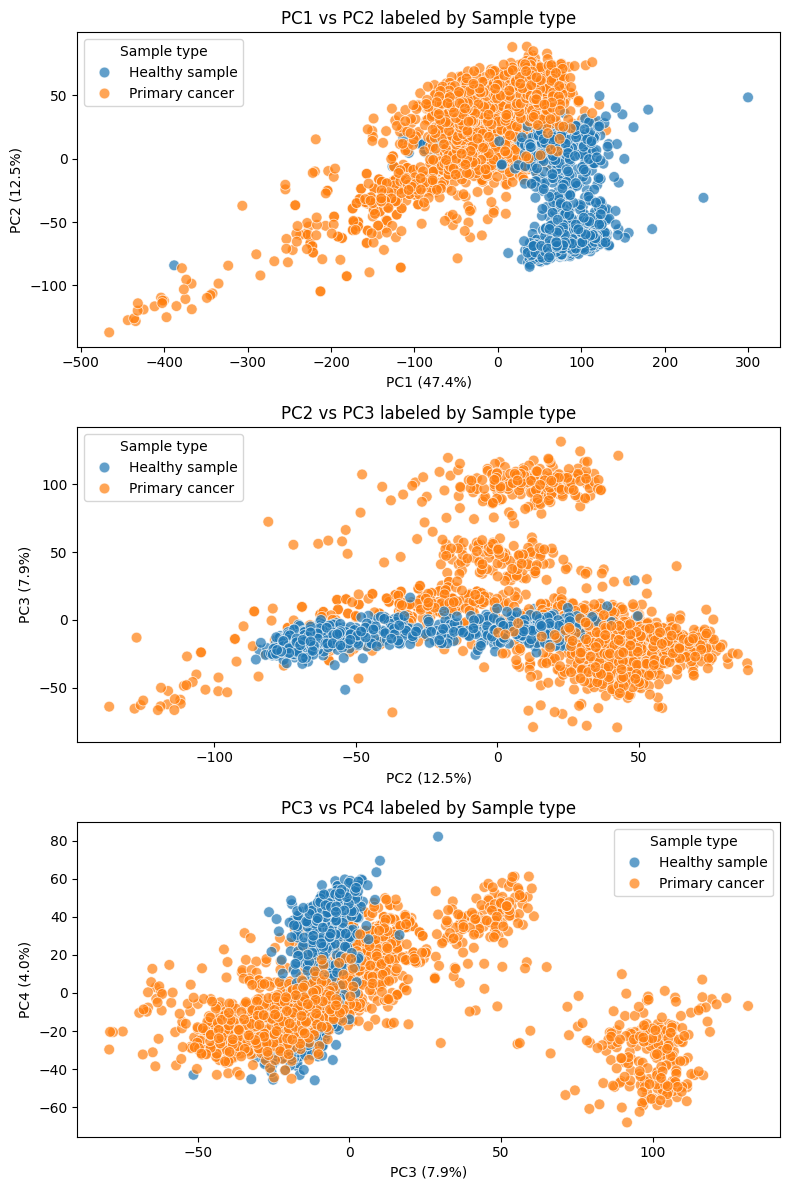

In [57]:
plotter.pca_components(pca_df_merged, pca, 'Sample type', 4) 

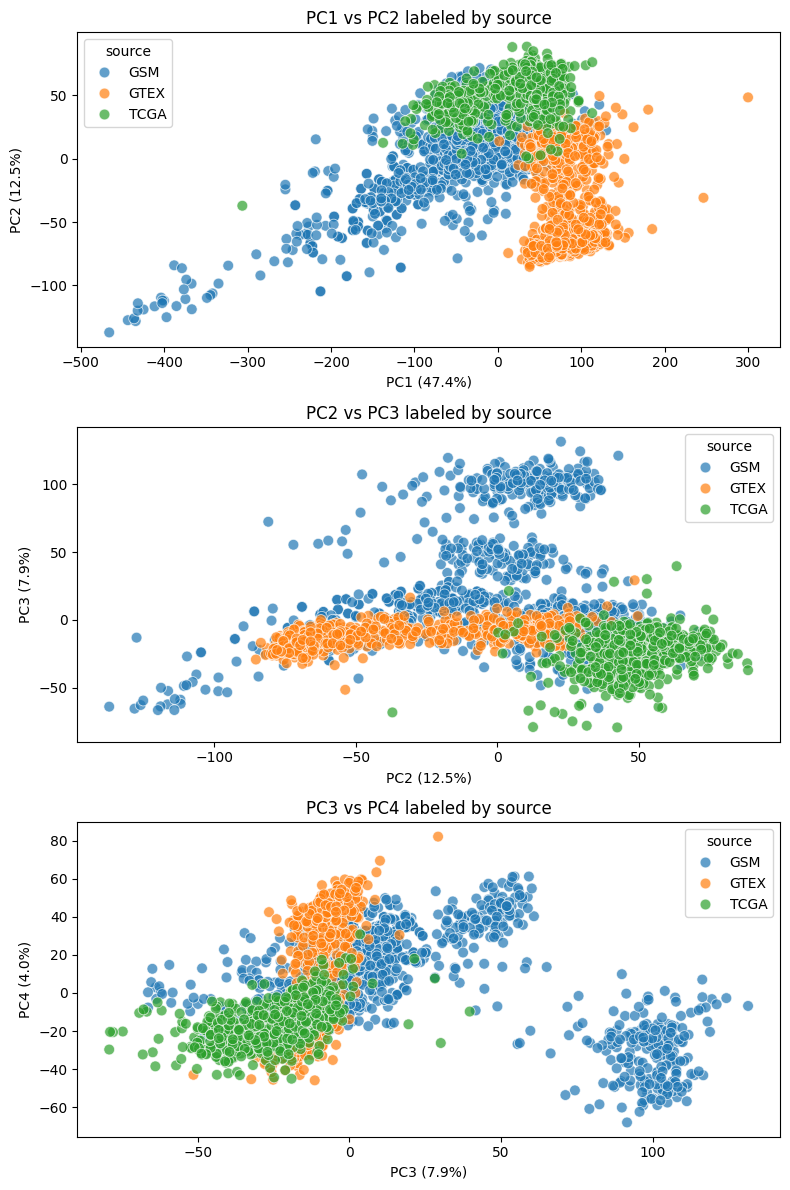

In [58]:
plotter.pca_components(pca_df_merged, pca, 'source', 4) 

The dataset is clearly separated by sample type. This means the tumor singal is clear in the data.\
It also suffer by batch effect by source dataset(source). This is expected as highly correlated with the sample type, as discussed before. In fact, while GTEX and TCGA are quite separated, GEO is more distributed/merged with the 2.\
I won't run another round of batch correction for source as I will do an analysis on cancer markers. Only TCGA samples will have the data I need: no batch effect as they will come from the same source dataset.

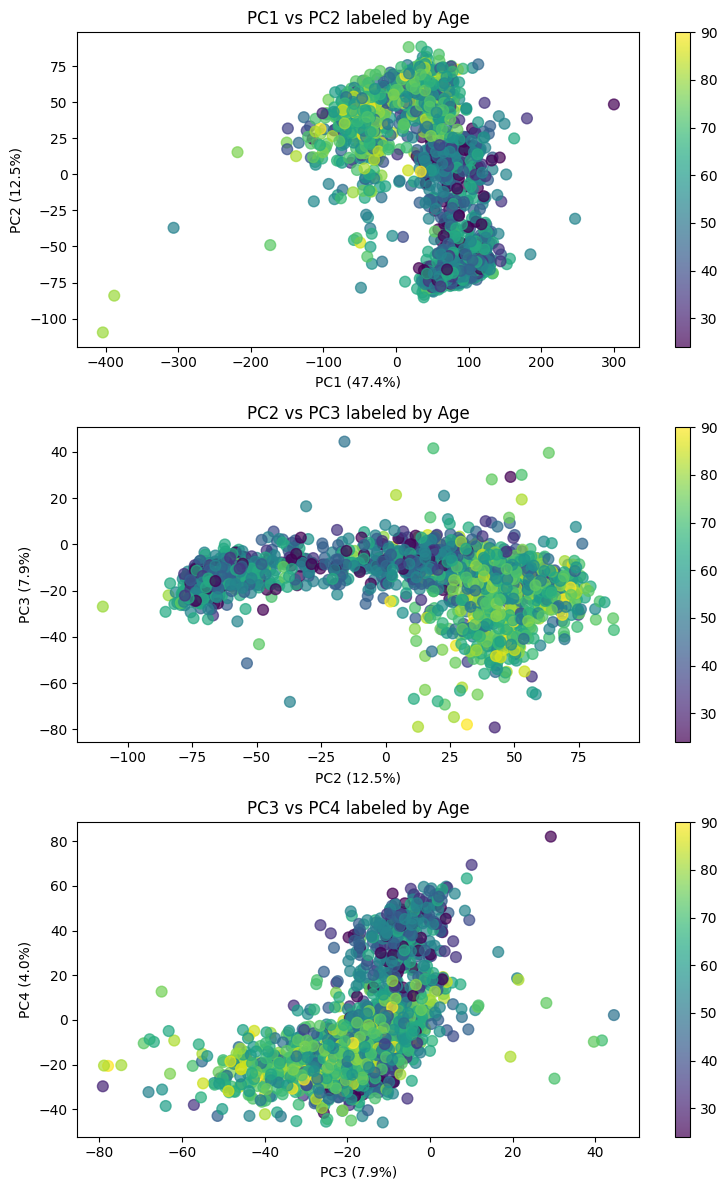

In [59]:
plotter.pca_components(pca_df_merged, pca, 'Age', 4)

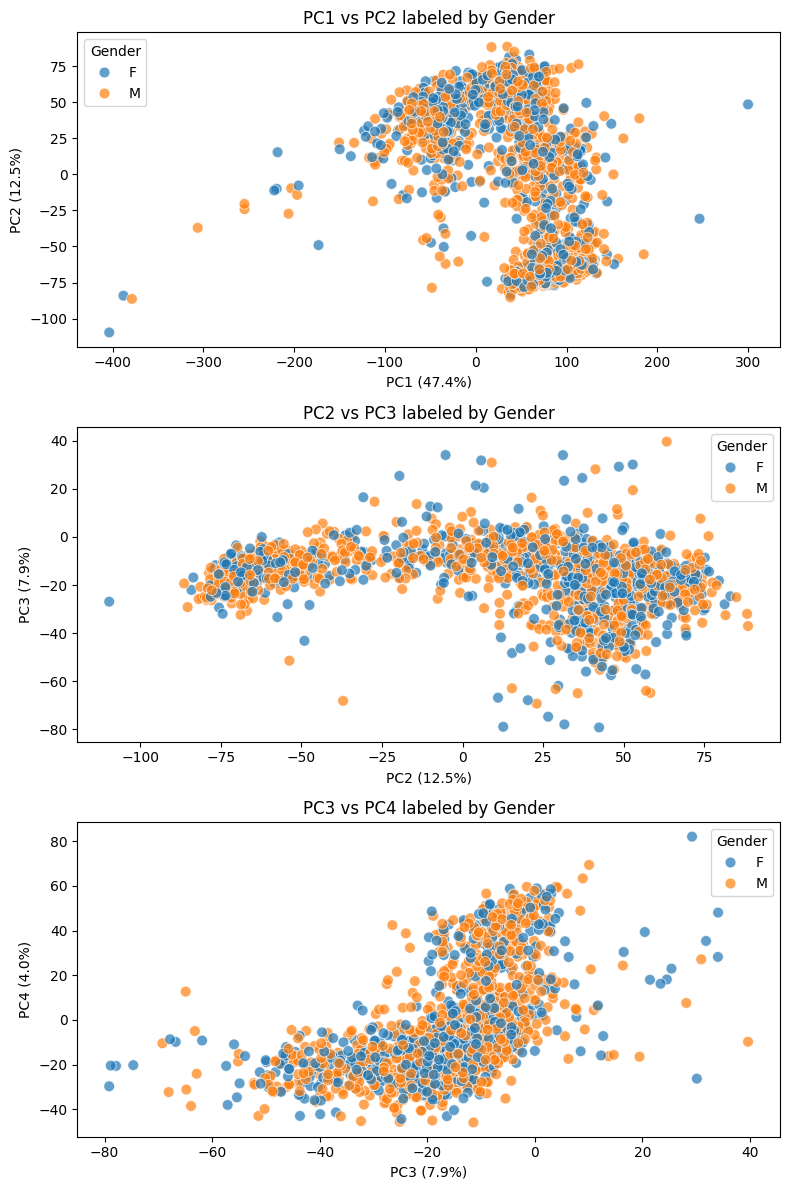

In [60]:
plotter.pca_components(pca_df_merged, pca, 'Gender', 4)

Gender is data is quite mixed, in these first components there is no sign of clear distinction between the sexes. This is somewhat expected as cancer signal might be stronger.\
On the other hand, there is a distinction in expression between younger and older donors (lighter vs darker clouds). 

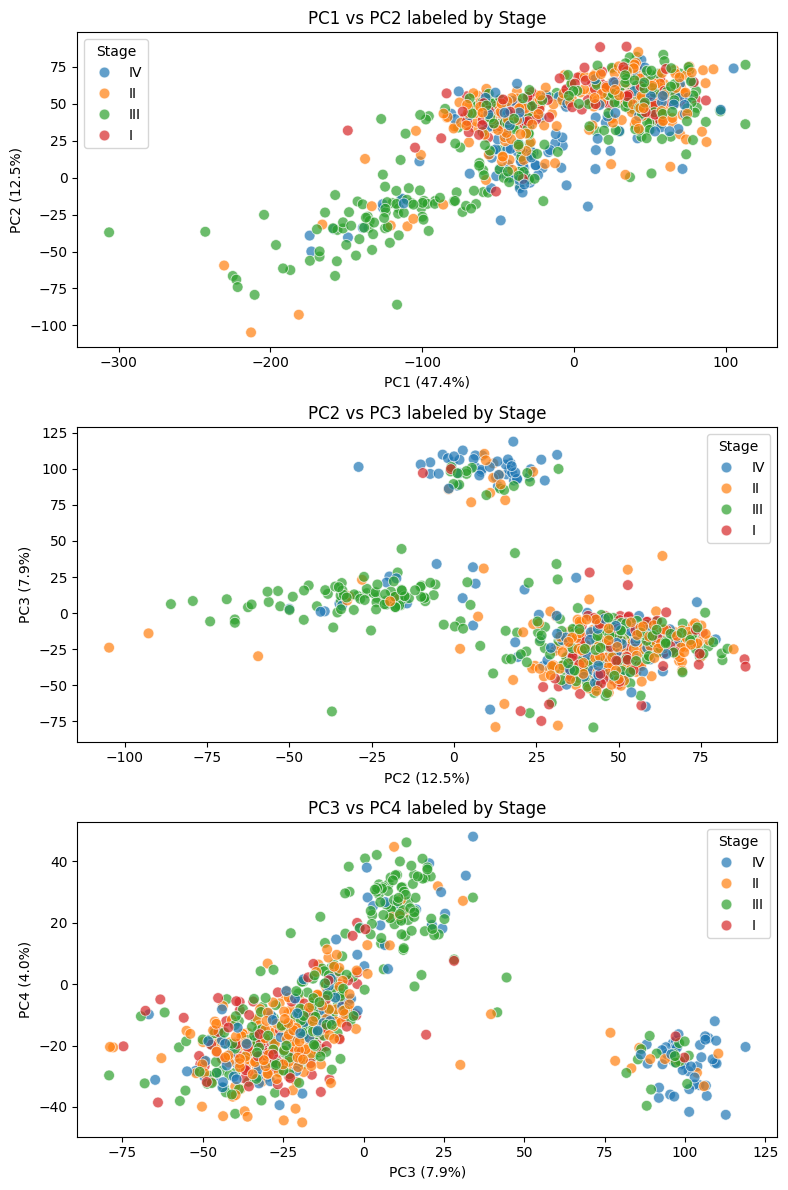

In [61]:
plotter.pca_components(pca_df_merged, pca, 'Stage', 4)

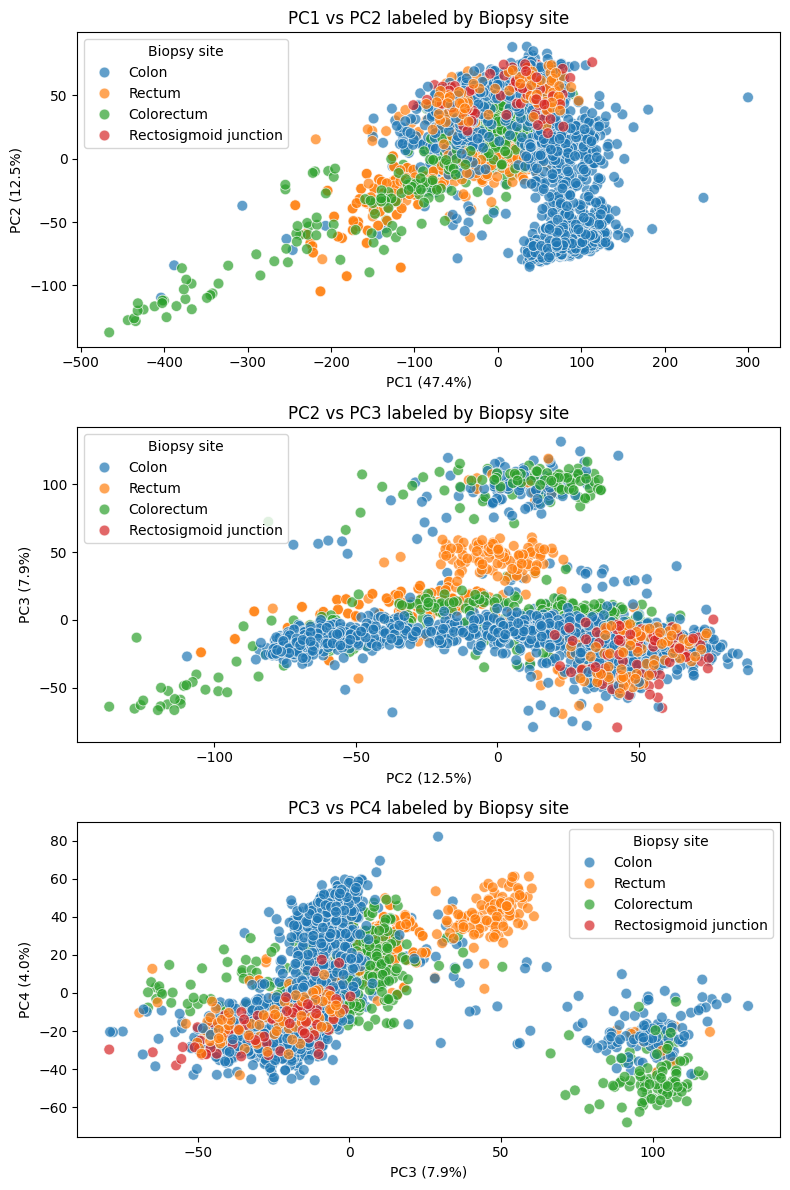

In [62]:
plotter.pca_components(pca_df_merged, pca, 'Biopsy site', 4)

While biopsy site is quite pocketed, it is not dominating the data separation.

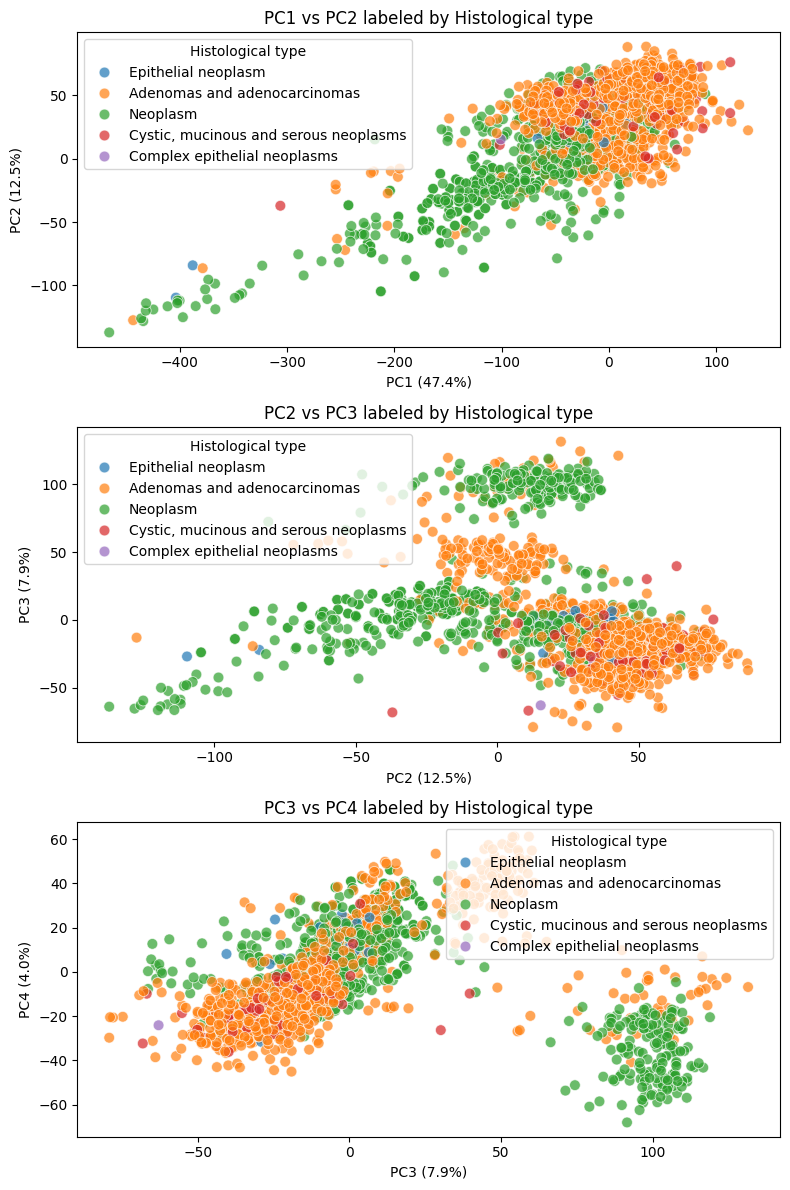

In [63]:
plotter.pca_components(pca_df_merged, pca, 'Histological type', 4)

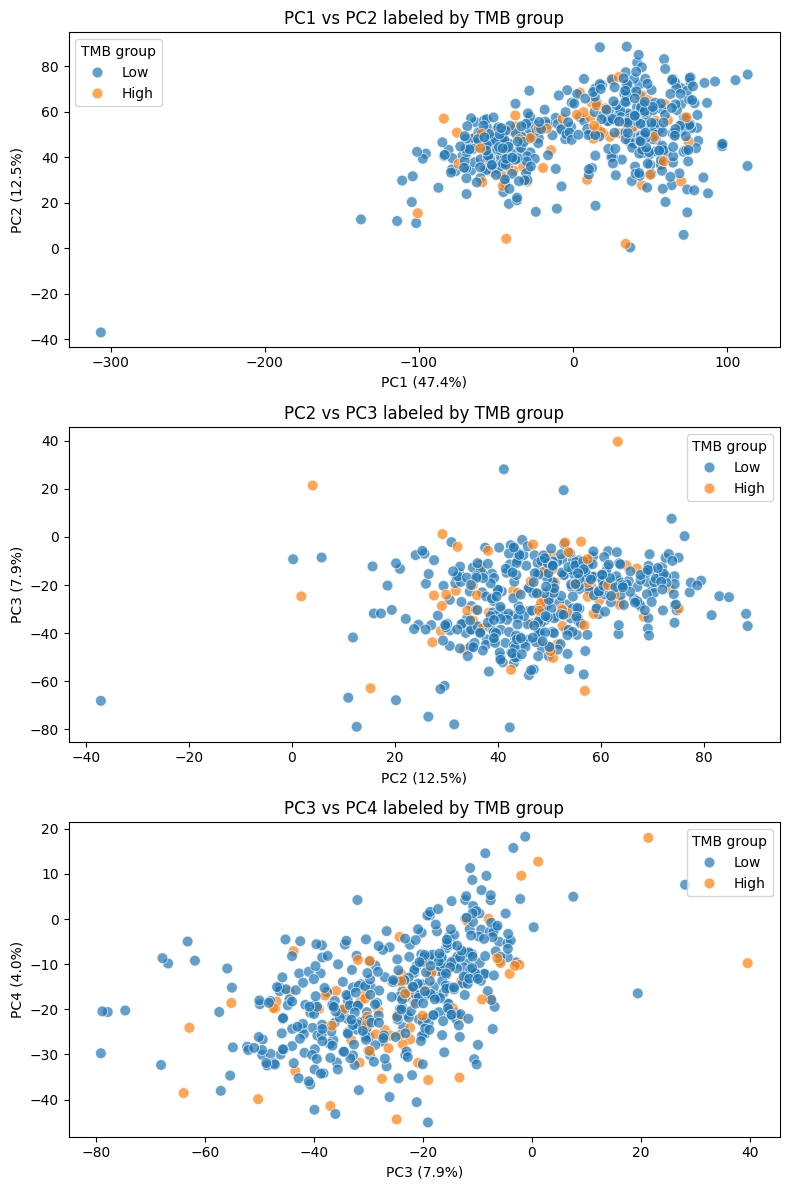

In [64]:
plotter.pca_components(pca_df_merged, pca, 'TMB group', 4)

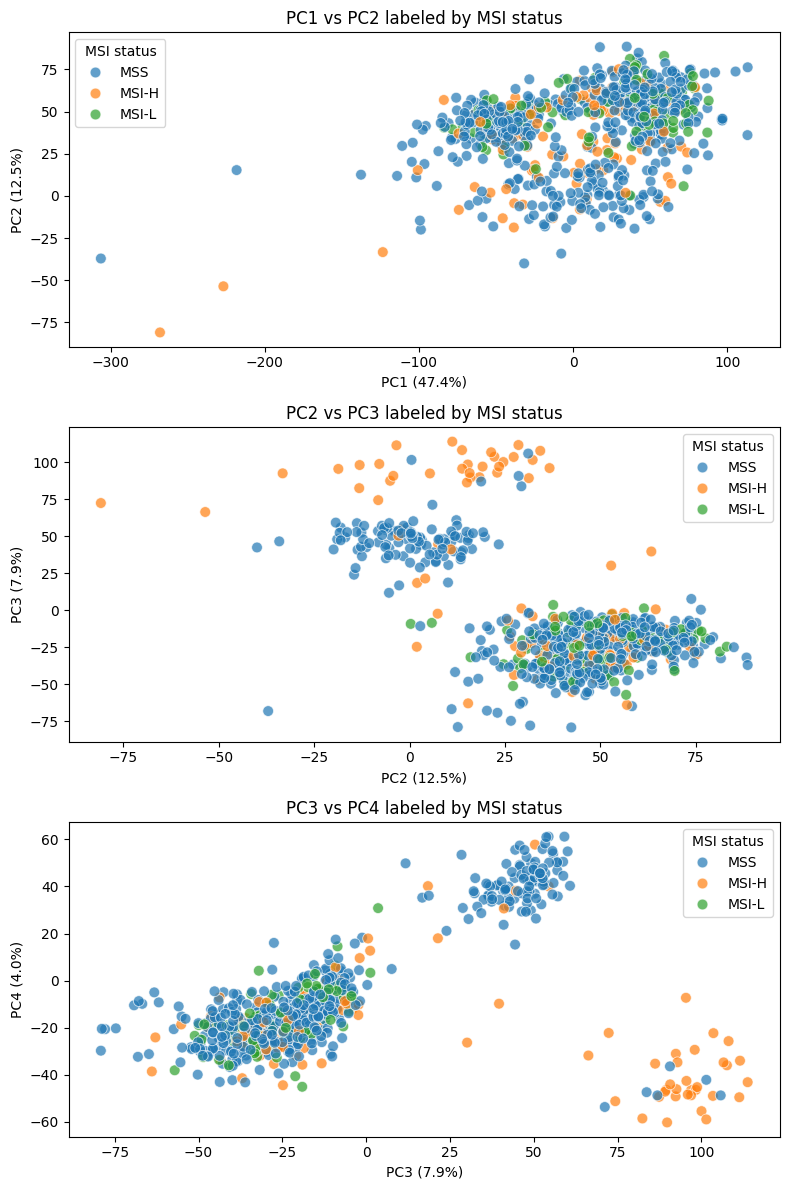

In [65]:
plotter.pca_components(pca_df_merged, pca, 'MSI status', 4)

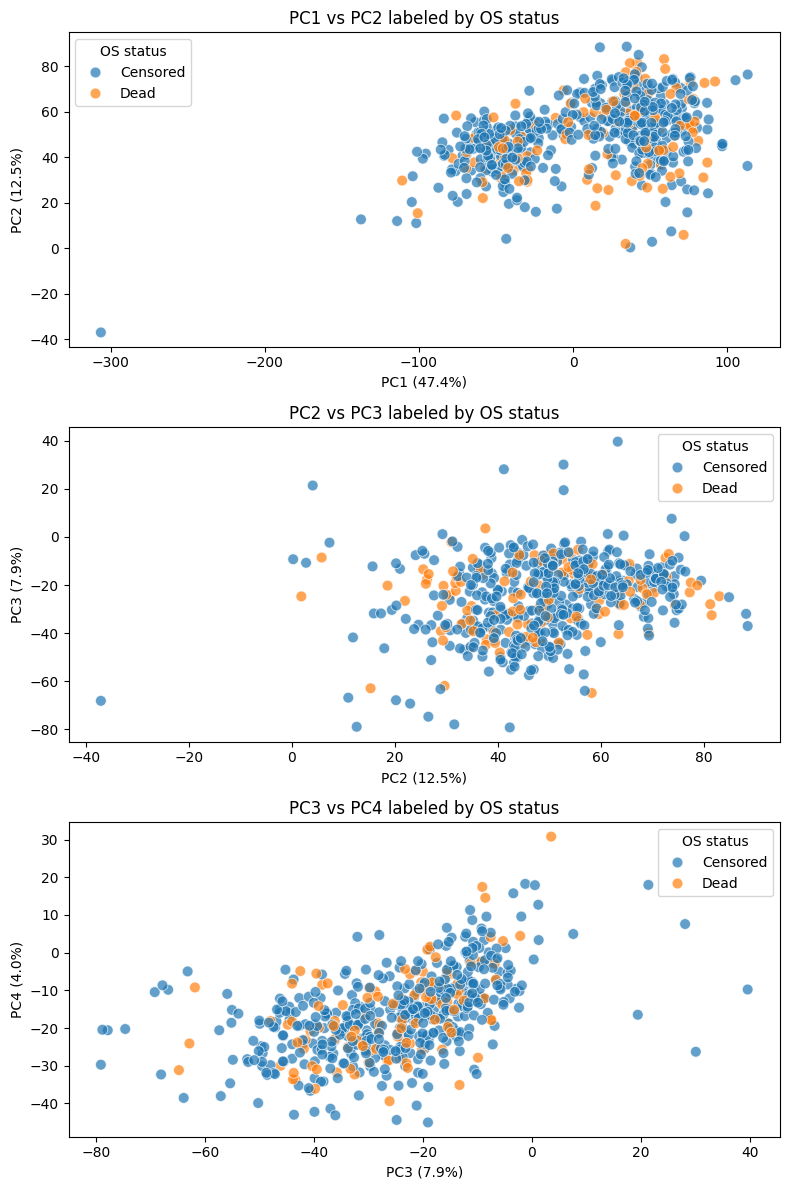

In [66]:
plotter.pca_components(pca_df_merged, pca, 'OS status', 4)

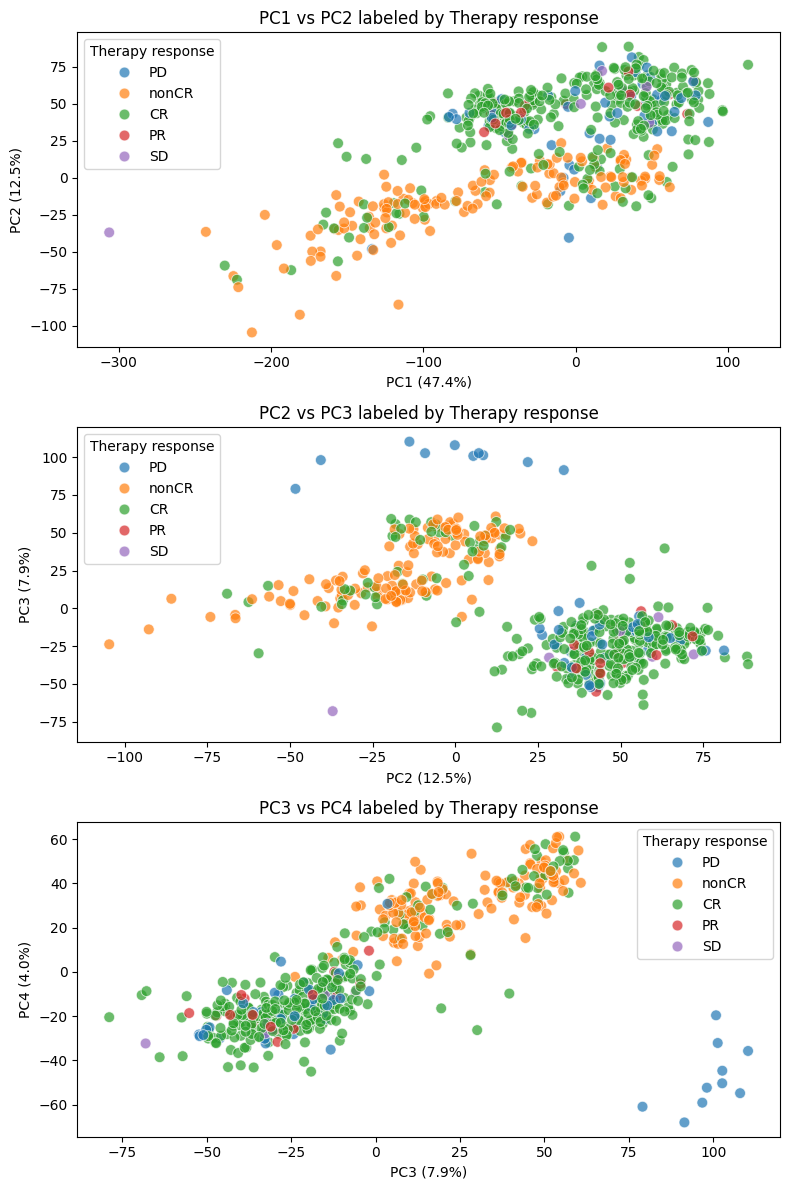

In [67]:
plotter.pca_components(pca_df_merged, pca, 'Therapy response', 4)

##### Considerations: 
The PCA shows that the dataset is partitioned on Sample type: TUMOR/HEALTY and on DATASET of ORIGIN.\
This is on top of the batch effect correction on sample type and biopsy site.\
No sign of partition by sex. I would have expected this to show but probably there is stronger signal due to sample type and batch effect of the dataset of origin. It might also be that sex signal would show up on other components.\
Tumor stage, therapy response and histological type are somewhat divided by PCA while the other features are not, at least by the first 4 components.

### STEP 5: Possible analysis routes
I present here some of the possible analyses that could be performed on this dataset.
1. Tumor vs Normal gene differential expression: 
    > BIOLOGICAL DRIVE: show which genes are more or less expressed in cancer tissue compared to healthy one and compare with known genes. It helps the development of new models since most genes are probably already known;  
    > DATA: all expression data + 'sample_type' from clinical data (and 'source' for batch correction);  
    > APPROACH: differential expression analysis with pydeseq2 or new developed models.  
2. Tumor stage/grade differential expression analysis:  
    > BIOLOGICAL DRIVE: show genes more/less expressed depending on tumor stage;  
    > DATA: expression data of tumor sample + tumor stage and grade (and 'source' for batch correction).  
    > APPROACH: differential expression analysis with pydeseq2.  
3. TUMOR MUTATIONAL/MOLECULAR singature impact on gene expression (THE ONE I WILLL PERFORM LATER)
    > BIOLOGICAL DRIVE: discover gene signatures for each CMS subtype, MSI status and TMB.  
    > DATA: expression data of tumor samples + some of CMS, MSI, TMB and genes mutation status.  
    > APPROACH: differential expression analysis with pydeseq2.  
4. Treatment Response Prediction:  
    > BIOLOGICAL DRIVE: predict therapy response from pre-treatment gene expression differences.  
    > DATA: expression data of tumor samples + 'Therapy response', 'Therapy type' + 'Prior treatment'.  
    > APPROACH: train a ML classifier on the expression data to discover for different gene profile the best therapy type.  
5. Survial analysis:
    > BIOLOGICAL DRIVE: show which genes (+ [relationship between TMB value and overall survival](https://pmc.ncbi.nlm.nih.gov/articles/PMC8576223/)) predict patient survival.  
    > DATA: expression data + OS status, OS time, PFS status, PFS time, TMB group, (+ Stage, Grade, Age which are correlated to survival).  
    > APPROACH: 
6. Treatment Response differential expression:  
    > BIOLOGICAL DRIVE: predict general therapy response from pre-treatment gene expression differences.  
    > DATA: expression data of tumor samples + 'Therapy response', 'Therapy type' + 'Prior treatment'.  
    > APPROACH: train a ML classifier on the expression data to discover for different gene profile the best therapy type.  

### STEP 6: EXPLORATORY ANALYSIS FOR TUMOR MUTATIONAL BOURDEN
This is the implementation is an exploratory version of point 3 and 5. I will look for differentially expressed genes in TMB high vs low samples and will perform a first survival plot between the two samples.\
The goal of this analysis is to identify gene expression signature that distinguishes tumors that are characterized for high mutations from those that do not. Moreover I will try to assess the difference between the TMB high and TMB low groups in term of survival.\
As TMB group and MSI status are higlhy correlated, I expect that a great part of the gene signature associated with TMB group will aslo be the same for MSI status. I will therefore explore if this is true and to wich degree the two signatures are entangled.\
I will also look at the pathways enriched by TMB high genes not present in MSI high signature. Finally I'll verify if TMB high only genes are associated with different outcomes in overall survival.\
This is intended as a first step of what could be a more comprehensive and detailed analysis on TMB and MSI interaction at the gene expression level. It can also be used as first step for the search of specific biomarkers associated with survival and treatment response. 

In [68]:
expression_data = expression_data.astype(int)
expression_data = expression_data.dropna()

I will do the differntial expression analysis taking into consideration the Age, as it showed separation, MSI status (highly correlated with TMB) and TMB group. Stage is also an affecting variable of cancer diversity.

In [69]:
clinical_data_dd = clinical_data[["source", "TMB group","MSI status","Age", "Stage"]].copy()
clinical_data_dd = clinical_data_dd.dropna()
clinical_data_dd

source TMB group MSI status  Age Stage
TCGA-A6-2671-01A-01R-1410-07   TCGA       Low        MSS   85    IV
TCGA-A6-2672-01B-03R-2302-07   TCGA      High      MSI-H   82   III
TCGA-A6-2674-01A-02R-0821-07   TCGA       Low        MSS   71    IV
TCGA-A6-2675-01A-02R-1723-07   TCGA       Low        MSS   78    II
TCGA-A6-2676-01A-01R-0826-07   TCGA      High      MSI-H   75    II
...                             ...       ...        ...  ...   ...
TCGA-F5-6861-01A-11R-1928-07   TCGA       Low        MSS   60    II
TCGA-F5-6863-01A-11R-1928-07   TCGA       Low      MSI-L   71   III
TCGA-F5-6864-01A-11R-1928-07   TCGA       Low      MSI-L   74   III
TCGA-G5-6235-01A-11R-1736-07   TCGA       Low        MSS   72   III
TCGA-G5-6641-01A-11R-A32Z-07   TCGA       Low        MSS   67   III

[487 rows x 5 columns]

In [70]:
clinical_data_dd["source"].describe()

count      487
unique       1
top       TCGA
freq       487
Name: source, dtype: object

In [71]:
clinical_data_dd = clinical_data_dd.drop('source', axis=1)

All samples come from the TCGA dataset. Batch effect from source dataset is therefore not a problem.

In [72]:
encoded_data_dd = pd.get_dummies(clinical_data_dd, columns=['TMB group','MSI status',"Stage"])
encoded_data_dd = encoded_data_dd.dropna()
encoded_data_dd

Age  TMB group_High  TMB group_Low  \
TCGA-A6-2671-01A-01R-1410-07   85           False           True   
TCGA-A6-2672-01B-03R-2302-07   82            True          False   
TCGA-A6-2674-01A-02R-0821-07   71           False           True   
TCGA-A6-2675-01A-02R-1723-07   78           False           True   
TCGA-A6-2676-01A-01R-0826-07   75            True          False   
...                           ...             ...            ...   
TCGA-F5-6861-01A-11R-1928-07   60           False           True   
TCGA-F5-6863-01A-11R-1928-07   71           False           True   
TCGA-F5-6864-01A-11R-1928-07   74           False           True   
TCGA-G5-6235-01A-11R-1736-07   72           False           True   
TCGA-G5-6641-01A-11R-A32Z-07   67           False           True   

                              MSI status_MSI-H  MSI status_MSI-L  \
TCGA-A6-2671-01A-01R-1410-07             False             False   
TCGA-A6-2672-01B-03R-2302-07              True             False   
TCGA-A6-2674-01A-02R-0821-07             False             False   
TCGA-A6-2675-01A-02R-1723-07             False             False   
TCGA-A6-2676-01A-01R-0826-07              True             False   
...                                        ...               ...   
TCGA-F5-6861-01A-11R-1928-07             False             False   
TCGA-F5-6863-01A-11R-1928-07             False              True   
TCGA-F5-6864-01A-11R-1928-07             False              True   
TCGA-G5-6235-01A-11R-1736-07             False             False   
TCGA-G5-6641-01A-11R-A32Z-07             False             False   

                              MSI status_MSS  Stage_I  Stage_II  Stage_III  \
TCGA-A6-2671-01A-01R-1410-07            True    False     False      False   
TCGA-A6-2672-01B-03R-2302-07           False    False     False       True   
TCGA-A6-2674-01A-02R-0821-07            True    False     False      False   
TCGA-A6-2675-01A-02R-1723-07            True    False      True      False   
TCGA-A6-2676-01A-01R-0826-07           False    False      True      False   
...                                      ...      ...       ...        ...   
TCGA-F5-6861-01A-11R-1928-07            True    False      True      False   
TCGA-F5-6863-01A-11R-1928-07           False    False     False       True   
TCGA-F5-6864-01A-11R-1928-07           False    False     False       True   
TCGA-G5-6235-01A-11R-1736-07            True    False     False       True   
TCGA-G5-6641-01A-11R-A32Z-07            True    False     False       True   

                              Stage_IV  
TCGA-A6-2671-01A-01R-1410-07      True  
TCGA-A6-2672-01B-03R-2302-07     False  
TCGA-A6-2674-01A-02R-0821-07      True  
TCGA-A6-2675-01A-02R-1723-07     False  
TCGA-A6-2676-01A-01R-0826-07     False  
...                                ...  
TCGA-F5-6861-01A-11R-1928-07     False  
TCGA-F5-6863-01A-11R-1928-07     False  
TCGA-F5-6864-01A-11R-1928-07     False  
TCGA-G5-6235-01A-11R-1736-07     False  
TCGA-G5-6641-01A-11R-A32Z-07     False  

[487 rows x 10 columns]

Checking that the conditions I am going to study are not correlated to age.

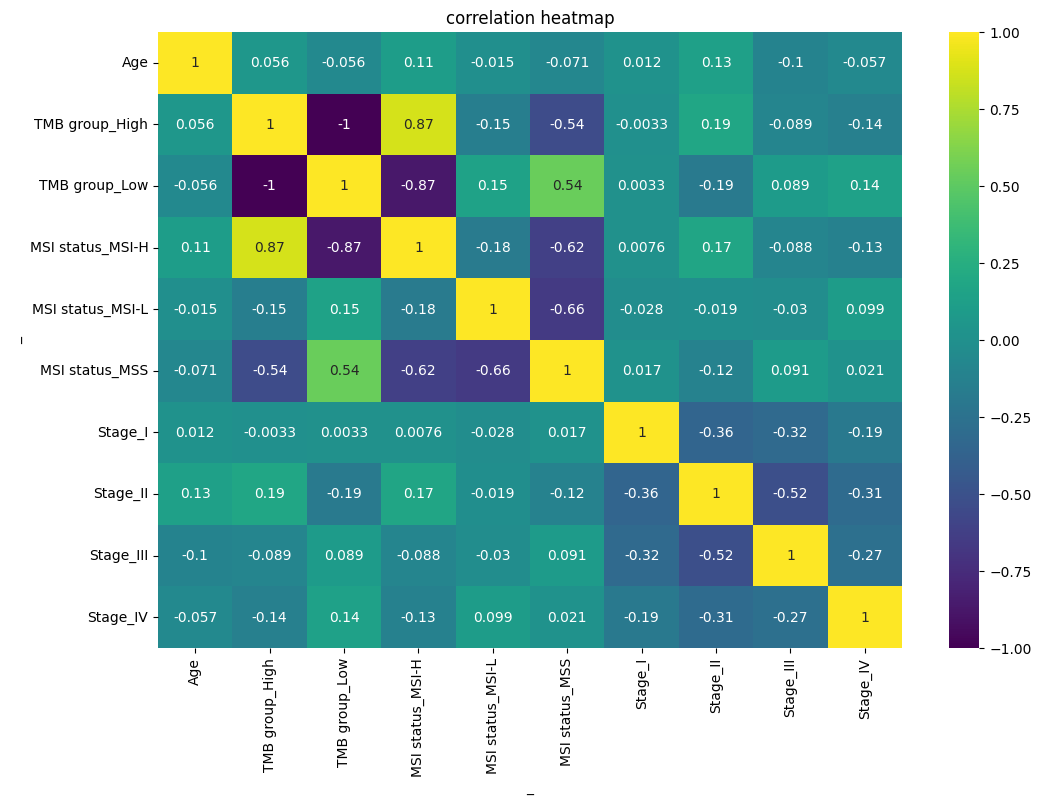

In [73]:
correlation_matrix_dd = encoded_data_dd.corr()
plotter.heatmap(correlation_matrix_dd, '_', '_', 'correlation heatmap')

In [74]:
print(correlation_matrix_dd)

                       Age  TMB group_High  TMB group_Low  MSI status_MSI-H  \
Age               1.000000        0.056016      -0.056016          0.108977   
TMB group_High    0.056016        1.000000      -1.000000          0.870091   
TMB group_Low    -0.056016       -1.000000       1.000000         -0.870091   
MSI status_MSI-H  0.108977        0.870091      -0.870091          1.000000   
MSI status_MSI-L -0.015034       -0.153660       0.153660         -0.178923   
MSI status_MSS   -0.071134       -0.541140       0.541140         -0.620083   
Stage_I           0.011935       -0.003281       0.003281          0.007562   
Stage_II          0.132586        0.187463      -0.187463          0.173247   
Stage_III        -0.104753       -0.089323       0.089323         -0.088162   
Stage_IV         -0.057334       -0.137518       0.137518         -0.131281   

                  MSI status_MSI-L  MSI status_MSS   Stage_I  Stage_II  \
Age                      -0.015034       -0.071134  0.01

TMB group high and MIS status High are highly correlated. There is a double square pattern in the correlation matrix, showing stage not so correlated with TMB and MSI. 
I will try do find a subset of genes that are differentially expressed for TMB high.\
I will now check other possible correlated features with TMB group high or low.

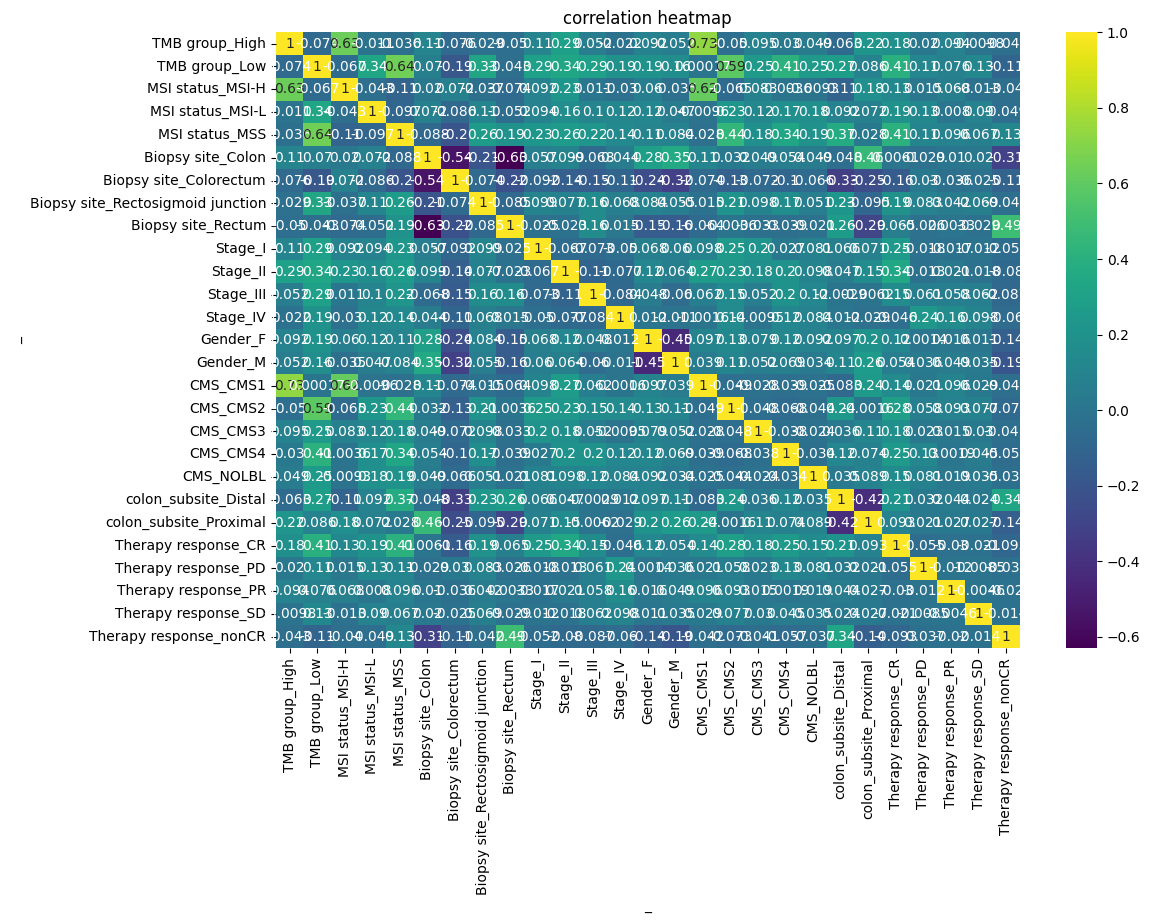

In [75]:
clinical_data_corr = clinical_data[['TMB group','MSI status','Biopsy site','Stage','Gender','CMS','colon_subsite','Therapy response']].copy()
encoded_data = pd.get_dummies(clinical_data_corr, columns=['TMB group','MSI status','Biopsy site','Stage','Gender','CMS','colon_subsite','Therapy response'])
encoded_data = encoded_data.dropna()
correlation_matrix = encoded_data.corr()
plotter.heatmap(correlation_matrix, '_', '_', 'correlation heatmap')

##### CONSIDERATIONS
I can see that for TMB group high, there is high correlation with CMS1 and MSI high.\
Since also MSI high is highly correlated with CMS1 (similar pattern with TMB low, MSI stable and CMS2), I will just consider the correlation of MSI with TMB in the differential expression analysis.

##### FOR THE DIFFERENTIAL EXPRESSION ANALYSIS
I need to avoid confounding between the effect of TMB and MSI. I want also to take into account the effect of Age and Stage showed by PCA.\
Adding both TMB and MSI to the design of the differential expression leads to skewed adjusted p-values torward 1, signaling a problem in separating the 2 effects. It is, in fact, difficult to pinpoint genes associated to the MSI vs TMB tumor characteristics as there are not enough samples with MSS or MSI-L and TMB-high (8).
The genes I will find differentially expressed in TMB-High vs Low will also largely reflect the overlap with MSI-H status. It is therefore, with this dataset, not possible to separated in a statistically sound way the MSI-H–specific from TMB-High–specific effects.\
I am going to look at the genes differentially expressed for TMB high samples vs low and the same for MSI high vs MSS. Then verify that the two effects are associated in the majority of those genes.

Computing samples common between filtered clinical and expression data

In [76]:
common_samples = expression_data.columns.intersection(clinical_data_dd.index)
expression_data_dd = expression_data.loc[:,common_samples]
clinical_data_dd = clinical_data_dd.loc[common_samples]
common_samples.shape

(453,)

I will now set the variables as categorical to be fed to pydeseq2

In [77]:
clinical_data_dd['Age'] = clinical_data_dd['Age'].astype('category')

clinical_data_dd['MSI_status'] = clinical_data_dd['MSI status'].astype('category')
clinical_data_dd.drop('MSI status', axis=1)

clinical_data_dd['TMB_group'] = clinical_data_dd['TMB group'].astype('category')
clinical_data_dd.drop('TMB group', axis=1)

clinical_data_dd['Stage'] = clinical_data_dd['Stage'].astype('category')

Now running the differential expression analysis with pydeseq2 from owkin, taking into account age and Stage before TMB group.\
My goal is to find genes specifically associated with high tumor mutational bourden. As MSI is so correlates it is difficult to distinguish them from the ones driven by microsatellite instability.\

In [78]:
design="~ Age + Stage + TMB_group"
dds_tmb = data_manipulator.run_differential_expression(expression_data_dd,clinical_data_dd, design )

Fitting size factors...
... done in 0.18 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 8.99 seconds.

Fitting dispersion trend curve...
... done in 0.23 seconds.

Fitting MAP dispersions...
... done in 11.17 seconds.

Fitting LFCs...
... done in 10.84 seconds.

Calculating cook's distance...
... done in 0.28 seconds.

Replacing 1511 outlier genes.

Fitting dispersions...
... done in 0.93 seconds.

Fitting MAP dispersions...
... done in 1.04 seconds.

Fitting LFCs...
... done in 1.63 seconds.



In [79]:
stat_res = DeseqStats(dds_tmb, contrast=["TMB_group", 'High', 'Low'])
stat_res.summary()
result = stat_res.results_df

Running Wald tests...


Log2 fold change & Wald test p-value: TMB_group High vs Low
              baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG          1.338437        0.268323  0.231192  1.160606  2.458021e-01   
A1BG-AS1      8.733536        0.291195  0.163678  1.779068  7.522853e-02   
A1CF        733.159243       -1.153553  0.136491 -8.451514  2.875491e-17   
A2M       12845.379328       -0.095501  0.140100 -0.681665  4.954509e-01   
A2M-AS1      15.061728        0.053350  0.138913  0.384050  7.009412e-01   
...                ...             ...       ...       ...           ...   
ZYG11A        3.680024        0.088321  0.255162  0.346137  7.292398e-01   
ZYG11B      900.099754        0.043538  0.066170  0.657979  5.105519e-01   
ZYX        7393.248305       -0.081488  0.089683 -0.908620  3.635508e-01   
ZZEF1      2157.750920        0.424640  0.088280  4.810120  1.508395e-06   
ZZZ3       1267.407123        0.068958  0.060872  1.132849  2.572777e-01   

                  padj  
A1

... done in 1.12 seconds.



In [80]:
signal_tmb = result[(result['padj'] < 0.01) & (abs(result['log2FoldChange']) > 2)]

In [81]:
print(f"High TMB vs Low TMB: found {len(signal_tmb)} significant differentially expressed genes.")
print(f"Upregulated in High TMB: {len(signal_tmb[signal_tmb['log2FoldChange'] > 0])}")
print(f"Downregulated in High TMB: {len(signal_tmb[signal_tmb['log2FoldChange'] < 0])}")

High TMB vs Low TMB: found 211 significant differentially expressed genes.
Upregulated in High TMB: 68
Downregulated in High TMB: 143


Comment: the differential expression analysis shows 35 genes associated to high TMB vs low TMB passing (quite stringent) significance tresholds.\
The genes are shown below.

In [82]:
signal_tmb.index

Index(['AC099792.1', 'ACE2', 'ACSL6', 'AFAP1-AS1', 'AIRE', 'AKNAD1', 'ALOXE3',
       'APCDD1', 'AQP5', 'ASCL2',
       ...
       'VSTM2L', 'VWA5B1', 'WFDC21P', 'WNT11', 'XPNPEP2', 'XXYLT1-AS2', 'ZIC2',
       'ZNF285', 'ZNF541', 'ZNF683'],
      dtype='object', length=211)

Histogram of adjusted p-value shows some genes passing significant treshold on the left and a lot of genes not doing so on the right.

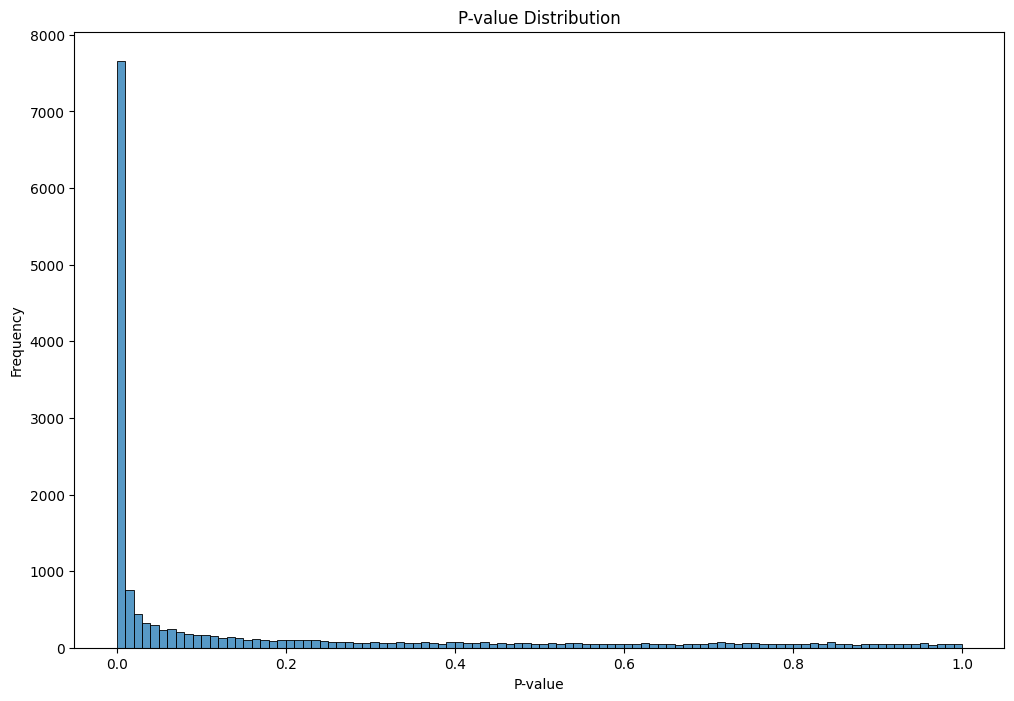

In [83]:
plotter.histogram(result, 'pvalue', 'P-value', 'Frequency', 'P-value Distribution')

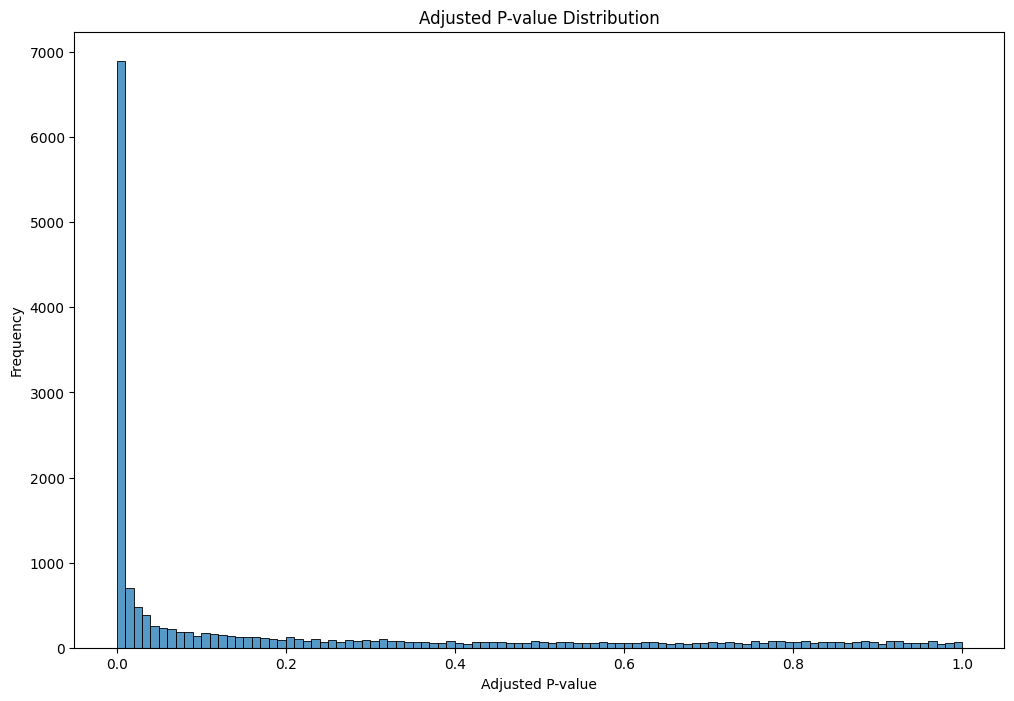

In [84]:
plotter.histogram(result, 'padj', 'Adjusted P-value', 'Frequency', 'Adjusted P-value Distribution')

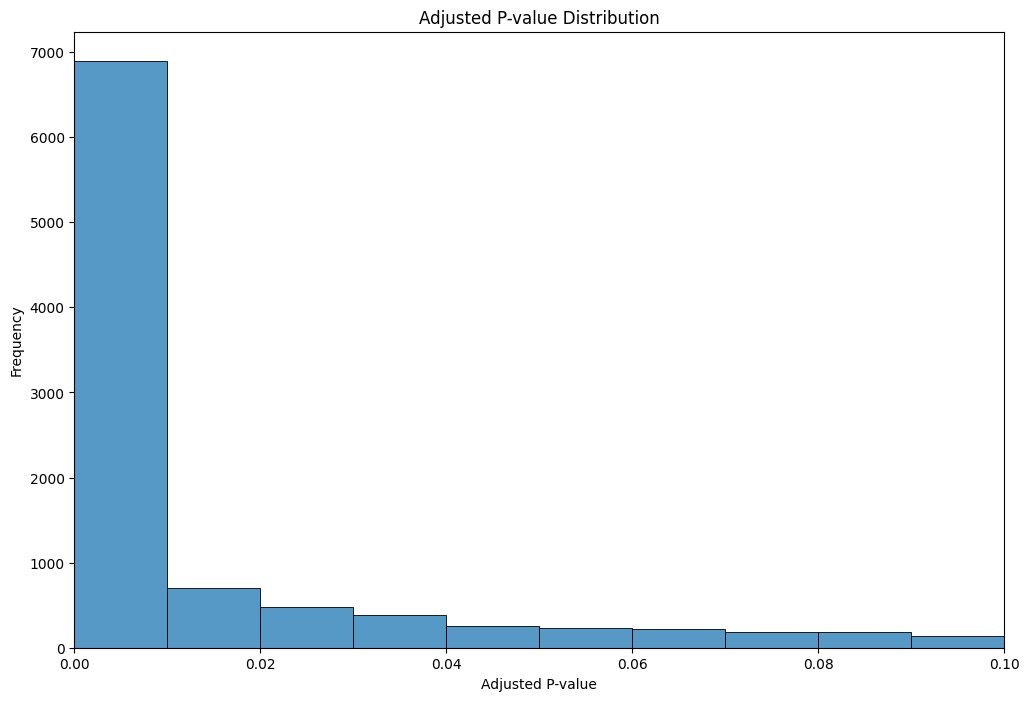

In [85]:
plotter.histogram(result, 'padj', 'Adjusted P-value', 'Frequency', 'Adjusted P-value Distribution', xrange=(0,0.1))

Adjusted p-value singals a large number of genes associated with the effect. This is in line with the effect of a important difference between expression of genes when there are a lot of mutations and not. Volcano plot will show how many the magnitude of such changes in expression (211 are interesting) . 

Vulan plot shows the adjusted p-value and log fold difference of genes. Red genes are overexpressed while blue genes are underexpressed.

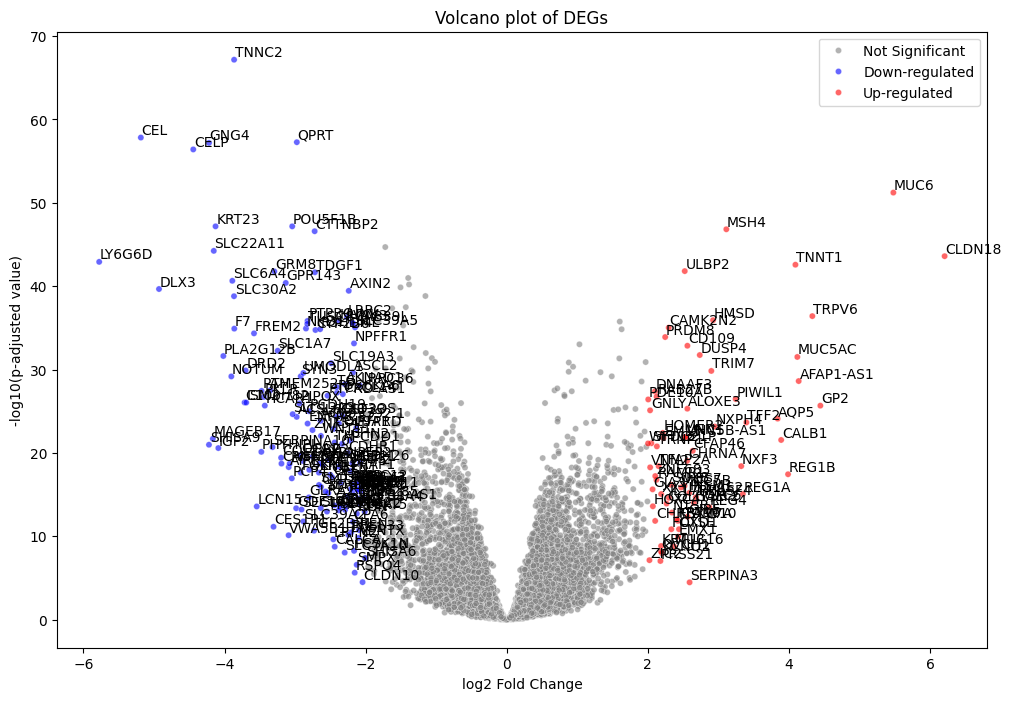

In [86]:
plotter.volcano(result, 'padj', 'log2FoldChange')

Now I do the same for MSI status

In [87]:
design_msi="~ Age + Stage + MSI_status"
dds_msi = data_manipulator.run_differential_expression(expression_data_dd,clinical_data_dd, design_msi )

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.21 seconds.

Fitting dispersions...
... done in 10.66 seconds.

Fitting dispersion trend curve...
... done in 0.24 seconds.

Fitting MAP dispersions...
... done in 12.76 seconds.

Fitting LFCs...
... done in 12.19 seconds.

Calculating cook's distance...
... done in 0.26 seconds.

Replacing 1511 outlier genes.

Fitting dispersions...
... done in 1.06 seconds.

Fitting MAP dispersions...
... done in 1.14 seconds.

Fitting LFCs...
... done in 1.82 seconds.



In [88]:
stat_res = DeseqStats(dds_msi, contrast=["MSI_status", 'MSI-H', 'MSS'])
stat_res.summary()
result_msi = stat_res.results_df

signal_msi = result_msi[(result_msi['padj'] < 0.01) & (abs(result_msi['log2FoldChange']) > 2)]

Running Wald tests...


Log2 fold change & Wald test p-value: MSI_status MSI-H vs MSS
              baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG          1.338437        0.374347  0.235848  1.587240  1.124583e-01   
A1BG-AS1      8.733536        0.329690  0.168185  1.960280  4.996306e-02   
A1CF        733.159243       -1.150422  0.140842 -8.168145  3.131663e-16   
A2M       12845.379328       -0.159214  0.144432 -1.102347  2.703110e-01   
A2M-AS1      15.061728        0.064131  0.143241  0.447711  6.543615e-01   
...                ...             ...       ...       ...           ...   
ZYG11A        3.680024       -0.252871  0.267637 -0.944828  3.447468e-01   
ZYG11B      900.099754        0.047639  0.068274  0.697760  4.853275e-01   
ZYX        7393.248305       -0.094822  0.092445 -1.025711  3.050280e-01   
ZZEF1      2157.750920        0.423595  0.090650  4.672863  2.970294e-06   
ZZZ3       1267.407123        0.070890  0.062791  1.128991  2.589018e-01   

                  padj  


... done in 1.15 seconds.



In [89]:
print(f"High MSI vs Stable MS: found {len(signal_msi)} significant differentially expressed genes.")
print(f"Upregulated in High MSI: {len(signal_msi[signal_msi['log2FoldChange'] > 0])}")
print(f"Downregulated in High MSI: {len(signal_msi[signal_msi['log2FoldChange'] < 0])}")

High MSI vs Stable MS: found 257 significant differentially expressed genes.
Upregulated in High MSI: 81
Downregulated in High MSI: 176


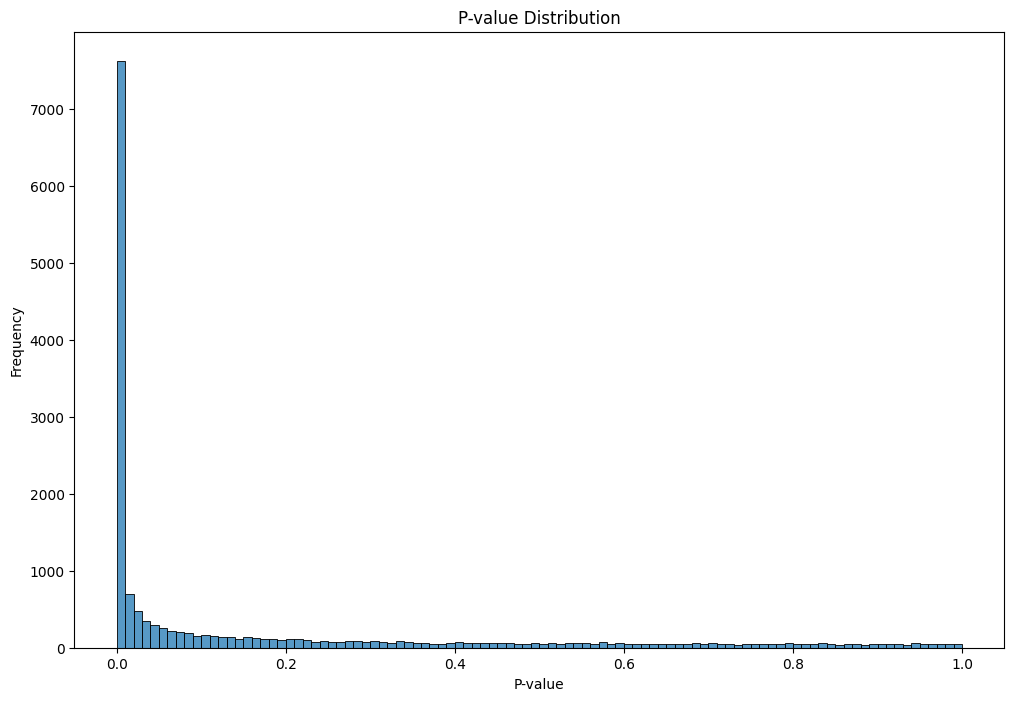

In [90]:
plotter.histogram(result_msi, 'pvalue', 'P-value', 'Frequency', 'P-value Distribution')

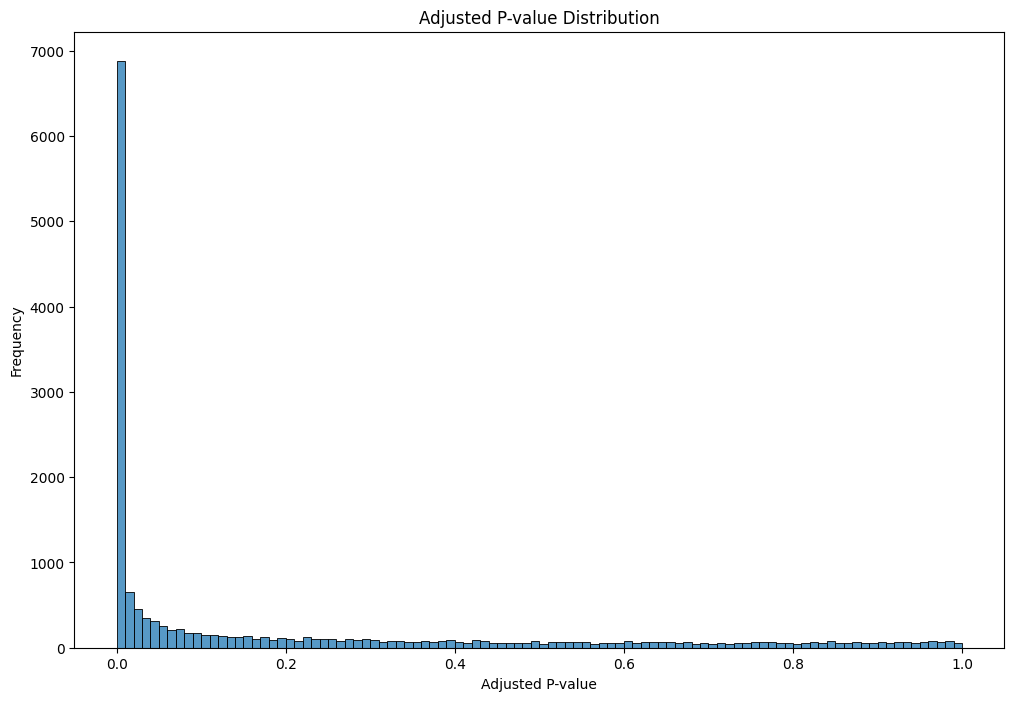

In [91]:
plotter.histogram(result_msi, 'padj', 'Adjusted P-value', 'Frequency', 'Adjusted P-value Distribution')

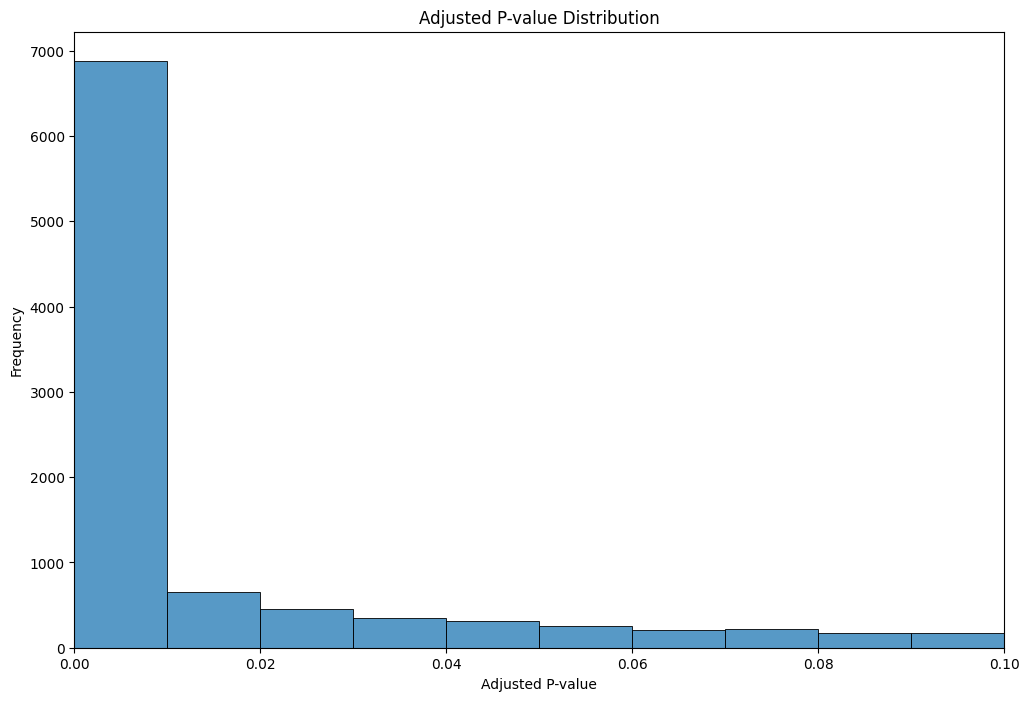

In [92]:
plotter.histogram(result_msi, 'padj', 'Adjusted P-value', 'Frequency', 'Adjusted P-value Distribution', xrange=(0,0.1))

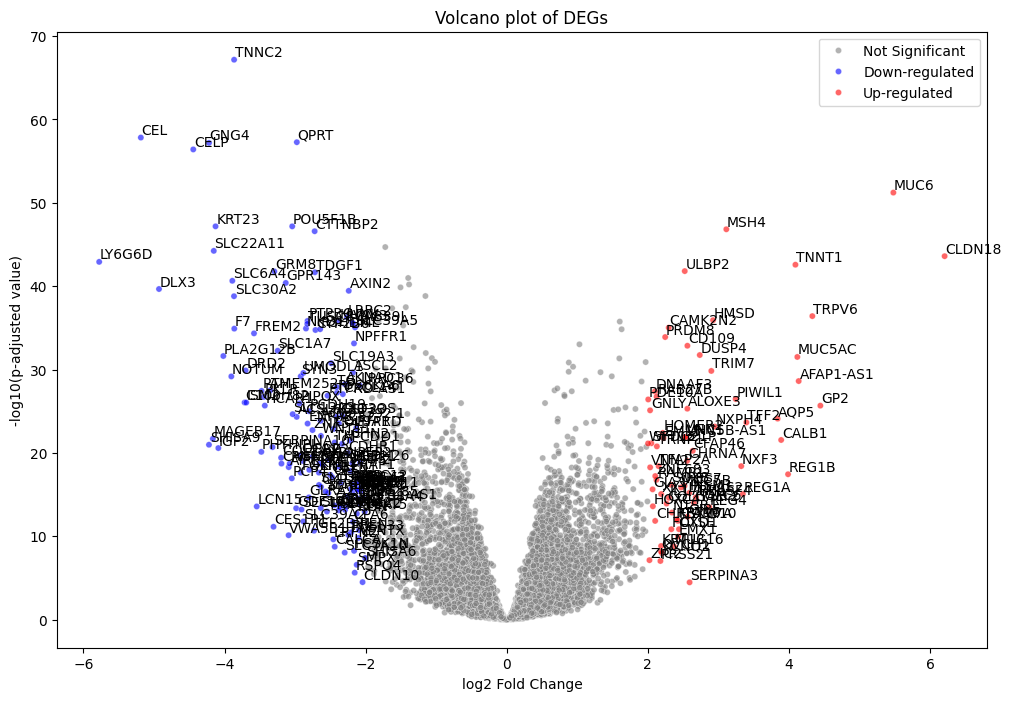

In [93]:
plotter.volcano(result, 'padj', 'log2FoldChange')

Now I plot a venn diagram of the two gene signatures to see how much TMB and MSI are connected.

In [94]:
tmb_genes = set(signal_tmb.index.tolist())
msi_genes = set(signal_msi.index.tolist())

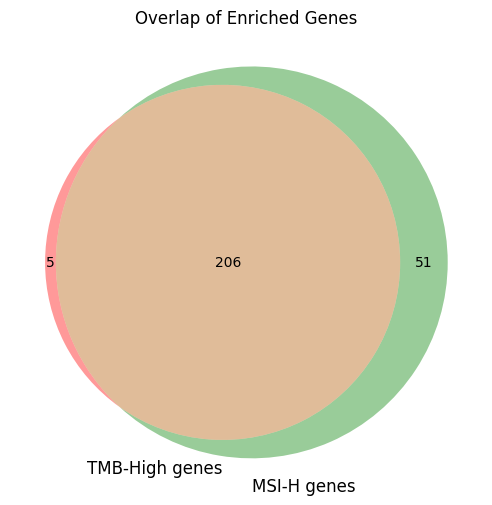

In [95]:
plotter.venn(tmb_genes, msi_genes, 'TMB-High genes', 'MSI-H genes', "Overlap of Enriched Genes")

Just 5 out of 211 genes are TMB-high specific and not shared with MSI. 51 are instead MSI only.
206 genes are, as suspected by strong correlation, shared between the two differential expression signatures.

For both TMB high only genes and MSI high only genes I will now research which pathways are regulated.

In [96]:
tmb_only_genes = tmb_genes.difference(msi_genes)
msi_only_genes = msi_genes.difference(tmb_genes)

In [97]:
tmb_only_genes

{'CDH26', 'CES1', 'CKMT2', 'PDE10A', 'RSPO4'}

In [98]:
enr_tmb = gseapy.enrichr(
    gene_list=list(tmb_only_genes),
    gene_sets=['KEGG_2021_Human', 'GO_Biological_Process_2021'],
    organism='human',
    outdir=None,
)

<Axes: title={'center': 'Enrichment of High TMB Genes'}, xlabel='Combined Score'>

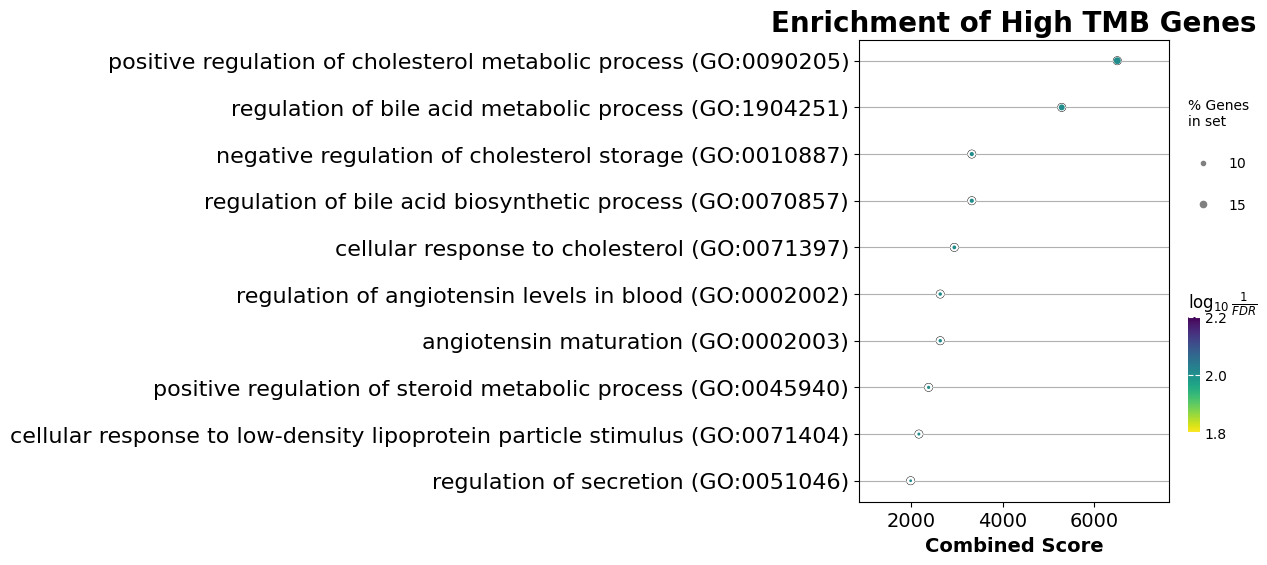

In [99]:
gseapy.dotplot(enr_tmb.res2d, title='Enrichment of High TMB Genes', figsize=(5,6), cutoff=0.05, show_ring=True)

TMB high (and not MSI high) genes are regulating metabolic/bile/steroid functions. It would be interesting to look forward on the interaction between those terms and why is so. This is omitted for sake of time/brevity.

In [100]:
enr_msi = gseapy.enrichr(
    gene_list=list(msi_only_genes),
    gene_sets=['KEGG_2021_Human', 'GO_Biological_Process_2021'],
    organism='Human',
    outdir=None,
)

In [101]:
msi_only_genes

{'AC010643.1',
 'ADGRG6',
 'AIFM3',
 'BEX2',
 'BRSK2',
 'C10orf67',
 'C10orf99',
 'CA1',
 'CHMP1B2P',
 'CP',
 'CRYBA2',
 'CTNNA2',
 'DPP10',
 'ELOVL3',
 'F10',
 'FAM155B',
 'GABRP',
 'GLYATL2',
 'IDO1',
 'KIAA1549L',
 'KIR2DL4',
 'KLHL34',
 'KRT6A',
 'LEFTY1',
 'LINC00654',
 'LINC00940',
 'LINC00942',
 'LRRN1',
 'MGC32805',
 'MIOX',
 'MYEF2',
 'NCR1',
 'NKX3-1',
 'OGDHL',
 'PCDH20',
 'PLCB4',
 'PNLIPRP2',
 'RBFOX1',
 'RPRM',
 'SCNN1B',
 'SERPIND1',
 'SIX2',
 'SLC26A3',
 'SLC34A2',
 'SV2C',
 'TINAG',
 'TMEM132C',
 'TRIM72',
 'TRPM6',
 'UGT2A3',
 'VANGL2'}

<Axes: title={'center': 'Enrichment of High MSI Genes'}, xlabel='Combined Score'>

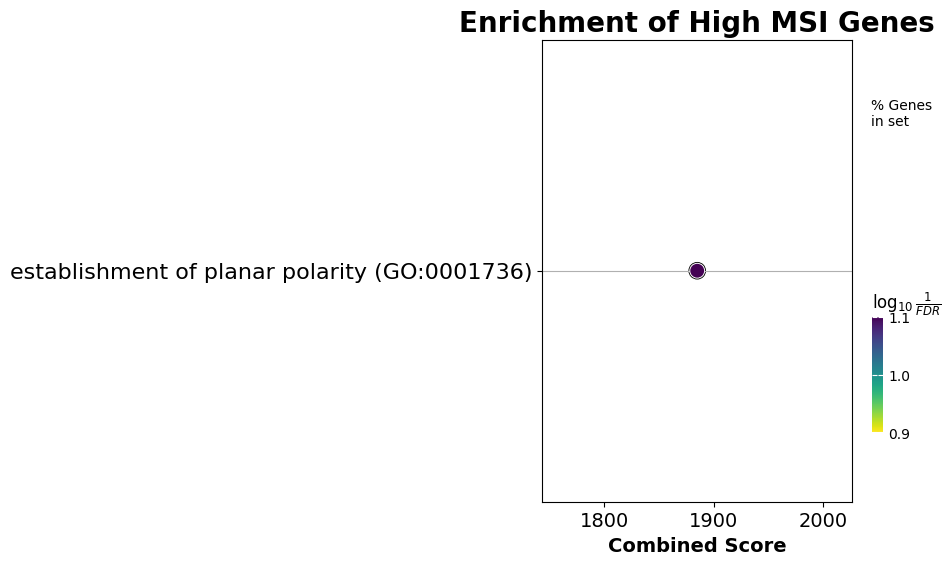

In [102]:
gseapy.dotplot(enr_msi.res2d, title='Enrichment of High MSI Genes', figsize=(5,6), cutoff=0.05, show_ring=True)

The only statistically significant pathway for MSI only is planar polarity, that determines cell disposition and it is a known marker of cancer.

Finally, I plot the overall survival of patients based on TMB group. 

In [103]:
status_map = { "Dead": 1, "Censored": 0}
km_df = clinical_data[['OS time', 'OS status', 'TMB group']].dropna().copy()
km_df = km_df[km_df['TMB group'].isin(['High','Low'])].copy()
km_df["OS status"] = km_df["OS status"].replace(status_map).astype(int)
km_df["OS time"] = pd.to_numeric(km_df["OS time"], errors="coerce")
km_df = km_df.dropna(subset=["OS time", "OS status"])

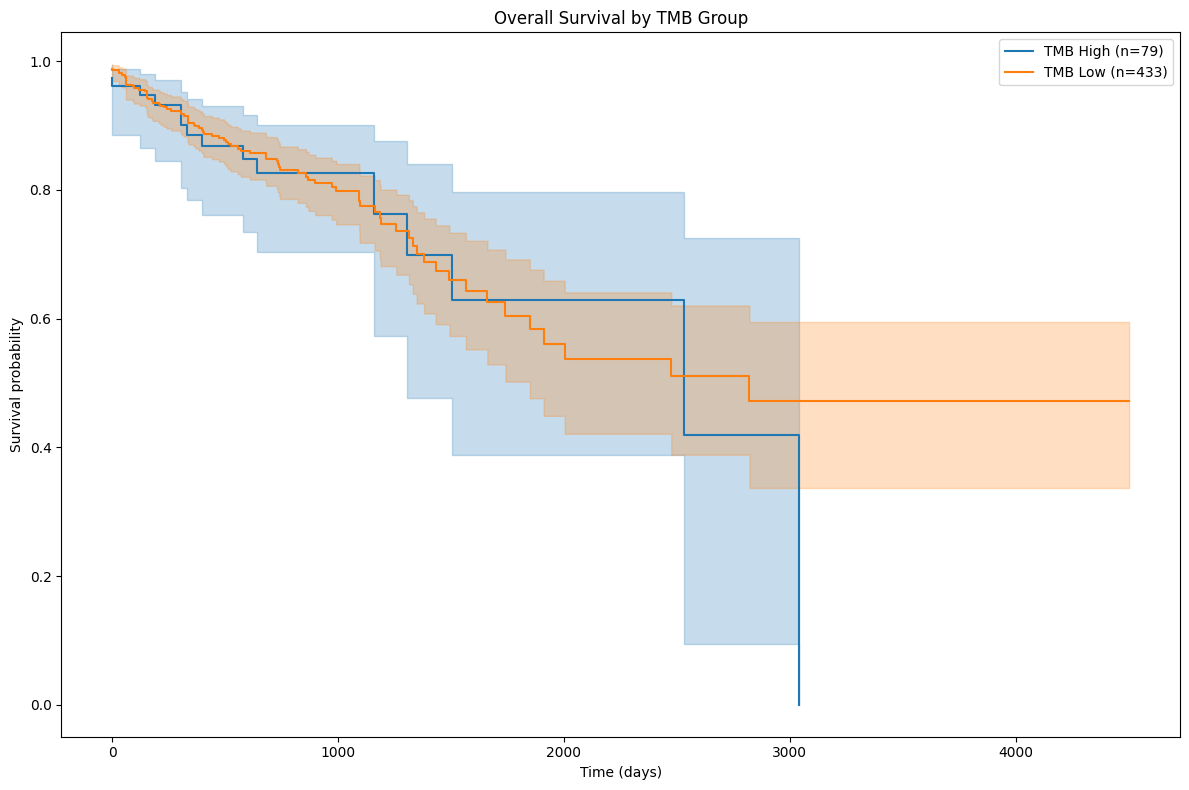

In [104]:
plotter.survival(km_df, x_lab= "Time (days)", y_lab= "Survival probability", title= "Overall Survival by TMB Group")

In [105]:
high_tmb_mask = km_df['TMB group'] == 'High'
low_tmb_mask = km_df['TMB group'] == 'Low'
logrank_test = logrank_test(
    km_df.loc[high_tmb_mask, 'OS time'], km_df.loc[low_tmb_mask, 'OS time'],
    event_observed_A=km_df.loc[high_tmb_mask, 'OS status'],
    event_observed_B=km_df.loc[low_tmb_mask, 'OS status']
)
print(f"Log-rank test p-value (TMB group High vs Low): {logrank_test.p_value:.3g} (<0.05 for statistical significance)")

Log-rank test p-value (TMB group High vs Low): 0.761 (<0.05 for statistical significance)


TMB status is therefore not impacting in a statistically significant way the overall survival of patients. This can also be seen by the survival plot, for which there is no strong difference between the two groups for > than 2000 days.\
I omit a final survival analysis on each TMB-high only expressed gene, as it does not show significance as well. It nevertheless shows that most of the time TMB-high gene markers show a lower survival probability in the right part of the plot (both if under-expressed or over-expressed). 

#### FINAL COMMENTS

I showed a brief example of pipeline to process bulk RNA-seq data from metadata and raw counts matrix.\
I consolidated the clinical data and QC-ed the expression data.\
I explored clinical data organization and showed source dataset batch effect in expression data using PCA.\
I then explored the differential expressed genes associated to high tumor mutational bourden and showed that the correlation found in clinical data is also present in the expression data as the vast majority of TMB-high DE genes are also MSI-high.\
I analyzed the enriched patways for both TMB-high only and MSI-high only DE genes.\
I finally showed the survival expectancy of the TMB-high and TMB-low patients and found no statistically significant difference.\
This is an example pipeline on how to analyze bulk RNA-seq and look for biologically meaningful signal in the data.